In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import theseus as th
import copy
from cvae_utilities import *
import copy
import os
import wandb
# Plot with matplotlib
import matplotlib.pyplot as plt


class CVAEWithTrajectoryOptimization(nn.Module):
    def __init__(self, cfg):
        super(CVAEWithTrajectoryOptimization, self).__init__()
        state_dim = cfg.state_dim
        action_dim = cfg.action_dim
        latent_dim_state = cfg.latent_dim_state 
        latent_dim_action = cfg.latent_dim_action
        horizon_action_dim = cfg.horizon * action_dim
        posterior_dim = cfg.posterior_dim
        device = cfg.device
        self.state_encoder = StateEncoder(state_dim, latent_dim_state).to(device)
        self.action_encoder = ActionEncoder(action_dim, latent_dim_action).to(device)
        self.fusing_encoder = FusingEncoder(latent_dim_state, horizon_action_dim, posterior_dim).to(device)
        self.dynamics_function = DynamicsFunction(latent_dim_state, action_dim, posterior_dim).to(device)
        self.action_decoder = ActionDecoder(posterior_dim, latent_dim_state, horizon_action_dim).to(device)
        self.reward_decoder = RewardDecoder(latent_dim_state, action_dim, posterior_dim).to(device)
        self.posterior_dim = posterior_dim
        self.device = device
        self.cfg = cfg

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, zs, za):
        """
        Perform a forward pass through the model.
        Args:
            obs: Observation (raw img input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            action: Action (latent action input), shape [batch_size, horizon * action_dim].
        Returns:
            reconstructed_action: Reconstructed action, shape [batch_size, horizon, action_dim].
            z_mu: Mean of the posterior Gaussian, shape [batch_size, posterior_dim].
            z_logvar: Log-variance of the posterior Gaussian, shape [batch_size, posterior_dim].
            _zs: Predicted next latent state, shape [batch_size, state_dim].
        """
    
        # Encode state and action
        # zs = self.state_encoder(obs, state)
        # za = self.action_encoder(action)

        # Fuse state and action for posterior Gaussian
        z_mu, z_logvar = self.fusing_encoder(zs, za)

        # Sample from posterior Gaussian
        fused_latent = self.reparameterize(z_mu, z_logvar)

        reconstructed_action = self.action_decoder(fused_latent, zs)

        zs_seq = []
        for t in range(self.cfg.horizon):
            _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action[:,2*t:2*(t+1)]), fused_latent)
            zs = _zs
            zs_seq.append(zs)
            fused_latent = _zp
        
        zs_seq = torch.stack(zs_seq, dim=1)

        return reconstructed_action, z_mu, z_logvar, zs_seq
    
    def generate_action(self, zs, zp):
        """
        Generate an action based on the given observation.
        Args:
            obs: Observation (raw state input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            z: Latent variable z, shape [batch_size, posterior_dim].
        Returns:
            action: Generated action, shape [batch_size, action_dim].
        """

        # Decode action from latent state and z
        reconstructed_action = self.action_decoder(zp, zs)  # Reconstruct action

        # _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action), zp)
        zs_seq = []
        for t in range(self.cfg.horizon):
            _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action[:,2*t:2*(t+1)]), fused_latent)
            zs = _zs
            zs_seq.append(zs)
            fused_latent = _zp
        
        zs_seq = torch.stack(zs_seq, dim=1)

        return reconstructed_action, _zs, _zp

    def save_pretrained(self, save_directory):
        """Save model weights and config to directory"""
        os.makedirs(save_directory, exist_ok=True)
        
        # Save model state dict
        model_path = os.path.join(save_directory, "model.pt")
        torch.save({
            'state_encoder': self.state_encoder.state_dict(),
            'action_encoder': self.action_encoder.state_dict(),
            'fusing_encoder': self.fusing_encoder.state_dict(),
            'dynamics_function': self.dynamics_function.state_dict(),
            'action_decoder': self.action_decoder.state_dict(),
            'reward_decoder': self.reward_decoder.state_dict(),
            'cfg': self.cfg
        }, model_path)

    def load_pretrained(self, load_directory):
        """Load model weights and config from directory"""
        model_path = os.path.join(load_directory, "model.pt")
        if not os.path.exists(model_path):
            raise ValueError(f"Model file not found at {model_path}")
            
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Load model weights
        self.state_encoder.load_state_dict(checkpoint['state_encoder'])
        self.action_encoder.load_state_dict(checkpoint['action_encoder'])
        self.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
        self.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
        self.action_decoder.load_state_dict(checkpoint['action_decoder'])
        self.reward_decoder.load_state_dict(checkpoint['reward_decoder'])
        
        # Load config
        self.cfg = checkpoint['cfg']

    def plan_with_theseus_update(self, obs, state, action, horizon, gamma, cfg, eval_mode=False):
        """
        Perform trajectory optimization using Theseus.
        Args:
            obs: Observation (raw state input).
            horizon: Planning horizon.
            gamma: Discount factor.
            model: The CVAE model containing dynamics and state encoders.
            cfg: Configuration object (for damping, step size, etc.).
            eval_mode: Whether to evaluate without gradients.
        """
        # Prepare initial observation
        batch_size = obs.shape[0]
        obs = obs[:,0,...].clone().detach().requires_grad_(True).to(self.device) # [bs, 3, 96, 96]
        state = state[:,0,...].clone().detach().requires_grad_(True).to(self.device)# [bs, 2]
        action = action.clone().detach().requires_grad_(True).to(self.device) # [bs, horizon * 2]
        horizon = int(min(horizon, cfg.horizon))  # Clip planning horizon

        # Initialize latent state and actions
          # Latent state
        # actions = torch.zeros(batch_size, horizon, cfg.action_dim, device=self.device, requires_grad=True)  # Initial actions

        # Precompute initial actions using policy (if available)
        pi_actions = torch.empty(batch_size, cfg.action_dim * horizon, device=self.device)
        expert_actions = action.view(batch_size, cfg.action_dim * horizon)
        zs = self.state_encoder(obs, state) # 【bs, 50]
        zs0 = zs.clone()

        zp = torch.randn(batch_size, self.posterior_dim, device=self.device)

        # for t in range(horizon):
        #     # pi_actions[:,t] = model.generate_action(obs, state, pz)
        #     if not eval_mode:
        #         za = self.action_encoder(action[:,2*t:2*(horizon+t)]) # [bs, 14]
        #         reconstructed_action, z_mu, z_logvar, (zs0, _) = self.forward(zs0, za) # [bs, 14]
        #         z_mus.append(z_mu)
        #         z_logvars.append(z_logvar)
        #     else:
        #         with torch.no_grad():
        #             reconstructed_action, zs0, zp = self.generate_action(zs0, zp)
        #     pi_actions[:,t] = reconstructed_action
        #     expert_actions[:,t] = action[:,2*t:2*(horizon+t)]


        if not eval_mode:
            za = self.action_encoder(action).view(batch_size, cfg.action_dim * horizon)
            pi_actions, z_mu, z_logvar, zs_seq = self.forward(zs0, za)
        else:
            with torch.no_grad():
                pi_actions = self.action_decoder(zp, zs)
        
        # Define cost function
        def value_cost_fn(optim_vars, aux_vars):
            actions = optim_vars[0].tensor  # [bs, horizon * action_dim]

            obs = aux_vars[0].tensor
            state = aux_vars[1].tensor
            pz = aux_vars[2].tensor

            actions = actions.view(actions.shape[0],  horizon, cfg.action_dim)
            tmp = torch.where(
                torch.abs(actions) > 1,
                (torch.abs(actions) - 1)**2,
                torch.zeros_like(actions)
            )
            actions = torch.clamp(actions, -1, 1) 

            z = self.state_encoder(obs, state)  # Latent state
            total_reward = 0.0
            discount = 1.0
            # pz = torch.randn(batch_size, self.posterior_dim, device=self.device)
            # Compute cumulative reward
            for t in range(horizon):
                reward = self.reward_decoder(z, actions[:,t], pz)
                z, pz = self.dynamics_function(z, actions[:,t], pz)
                total_reward += discount * reward
                discount *= gamma
            # print("tmp")
            # print(torch.clamp(tmp.sum(axis=[1,2]), max=1e3).shape)
            # print(torch.clamp(tmp.sum(axis=[1,2]), max=1e3).mean())
            err = -torch.nan_to_num(total_reward, nan=0.0) + 10# + torch.clamp(tmp.sum(axis=[1,2]), max=1e3).unsqueeze(1) * 100
            return err
        
        all_actions_var = []
        all_obs_var = []
        all_state_var = []
        all_zp = []

        for i in range(batch_size):
            actions_var = th.Vector(tensor = pi_actions[0].view(1, -1), name=f"actions_{i}")
            obs_var = th.Variable(obs[0].unsqueeze(0), name=f"obs_{i}")
            state_var = th.Variable(state[0].unsqueeze(0), name=f"state_{i}")
            posterior = th.Variable(zp[0].unsqueeze(0), name=f"posterior_{i}")
            all_actions_var.append(actions_var)
            all_obs_var.append(obs_var)
            all_state_var.append(state_var)
            all_zp.append(posterior)
        

        objective = th.Objective()
        for i in range(batch_size):
            cost_function = th.AutoDiffCostFunction(
                [all_actions_var[i]],
                value_cost_fn,
                dim=1,
                aux_vars=[all_obs_var[i], all_state_var[i], all_zp[i]],
                name=f"value_cost_fn_{i}",
            )
            objective.add(cost_function)
        optimizer = th.LevenbergMarquardt(
            objective,
            th.CholeskyDenseSolver,
            max_iterations=cfg.max_iterations,
            step_size=cfg.step_size,
        )
        theseus_layer = th.TheseusLayer(optimizer)
        theseus_layer.to(device=self.device)



        def construct_theseus_layer_inputs():
            theseus_inputs = {}
            for i in range(batch_size):
                theseus_inputs.update({
                    f"actions_{i}": pi_actions[i].view(1, -1),
                    f"obs_{i}": obs[i].unsqueeze(0), 
                    f"state_{i}": state[i].unsqueeze(0), 
                    f"posterior_{i}": zp[i].unsqueeze(0)})
            return theseus_inputs

        # Solve optimization problem
        theseus_input = construct_theseus_layer_inputs()
        updated_inputs, info = theseus_layer.forward(
            theseus_input,
            optimizer_kwargs={
                "track_best_solution": True,
                "damping": cfg.damping,
                "verbose": False,
                "backward_mode" : "implicit",
                "backward_num_iterations":10,
            },
        )

        batch_best_actions = []
        batch_updated_actions = []

        for i in range(batch_size):
            best_actions = info.best_solution[f"actions_{i}"]#.view(horizon, cfg.action_dim)
            updated_actions = updated_inputs[f"actions_{i}"].nan_to_num_(0)#.view(horizon, cfg.action_dim)
            batch_best_actions.append(best_actions)
            batch_updated_actions.append(updated_actions)

        batch_best_actions_tensor = torch.stack(batch_best_actions).squeeze(1)
        batch_updated_actions_tensor = torch.stack(batch_updated_actions).squeeze(1)

        if not eval_mode:
            # bc_loss = F.mse_loss(updated_actions[:,:1,:], expert_actions[:,:1,:])
            print(batch_updated_actions_tensor.min())
            print(batch_updated_actions_tensor.max())
            elbo_loss, recon_loss = compute_elbo_loss(batch_updated_actions_tensor, expert_actions, z_mu, z_logvar, cfg.beta)
            # bc_loss = F.mse_loss(batch_best_actions_tensor[:,:,:6], expert_actions[:,:,:6].cpu())
            output_dict = {
                "best_actions": batch_best_actions_tensor,
                "elbo_loss": elbo_loss,
                "recon_loss": recon_loss
            }
        else:
            bc_loss = F.mse_loss(batch_best_actions_tensor, expert_actions.cpu(),reduction = "mean")
            output_dict = {
                "bc_loss": bc_loss,
                "best_actions": batch_best_actions_tensor,
            }
        return output_dict


In [34]:
# # Example Usage
class Config:
    def __init__(self):
        self.horizon = 7
        self.action_dim = 2
        # Theseus optimization parameters
        self.max_iterations = 50
        self.step_size = 1e-2
        self.damping = 1e-3
        self.min_std = 1e-4
        self.discount = 0.99
        self.state_dim = 512*3*3 + 2
        self.batch_size = 16
        self.latent_dim_state = 50
        self.latent_dim_action = self.action_dim
        self.posterior_dim = 64
        self.device = torch.device("cuda")
        self.beta = 1.0
cfg = Config()
device = cfg.device

# Create CVAE model
model = CVAEWithTrajectoryOptimization(cfg)

# Example observation
obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
state = torch.randn(cfg.batch_size,1,2).to(device)
action = torch.randn(cfg.batch_size,7,2).to(device)
# obs = (obs, state)

# Perform trajectory optimization with Theseus
output_dict = model.plan_with_theseus_update(obs, state, action, horizon=cfg.horizon, gamma=cfg.discount, cfg=cfg, eval_mode=False)
# print("Optimized Actions:", optimized_actions)


tensor(-1.4951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7348, device='cuda:0', grad_fn=<MaxBackward1>)


In [35]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.

import wandb
import os
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import torch
from torch.utils.data import random_split
import numpy as np
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import tqdm
import gymnasium as gym
import gym_pusht

# Set PyTorch memory allocation config to avoid fragmentation
torch.cuda.set_per_process_memory_fraction(0.9)  # Limit max memory usage to 80%
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config_dict = {
        "horizon": 7,
        "action_dim": 2,
        "state_dim": 512*3*3 + 2,
        "batch_size": 64,  # Reduced batch size
        "latent_dim_state": 50,
        "latent_dim_action": 2,  # Same as action_dim
        "posterior_dim": 64,
        "beta": 10.0,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "max_iterations": 50,
        "step_size": 1e-4,
        "damping": 1e-3,
        "min_std": 1e-4,
        "discount": 0.9,
        "log_freq": 1,
        "eval_freq": 20,  # Evaluate every 100 steps
        "output_directory": "./output",
        "device": "cuda:0",
        "gradient_accumulation_steps": 4,  # Increased to compensate for smaller batch size
        "online_eval_episodes": 10,  # Number of episodes for online evaluation
    }

config = Config(config_dict)

# Initialize wandb first with all configuration parameters
wandb.init(
    project="difftop-training",
    config=config_dict,
    resume=True
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Set up the dataset
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

dataset = LeRobotDataset("lerobot/pusht_image", delta_timestamps=delta_timestamps)

episode_indices_to_use = np.arange(dataset.num_episodes)
test_episode_indices = np.random.choice(episode_indices_to_use, 10, replace=False)
train_episode_indices = np.setdiff1d(episode_indices_to_use, test_episode_indices)

train_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=train_episode_indices, shuffle=True)
test_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=test_episode_indices, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=train_sampler,
    pin_memory=True,
    drop_last=True,
)

eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=test_sampler,
    pin_memory=True,
    drop_last=True,
)

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()  # Clear cache before evaluation
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            obs = batch['observation.image']
            state = batch['observation.state']/512 * 2 - 1
            action = batch['action']/512 * 2 - 1
            output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config, eval_mode=True)
            total_loss += output_dict["bc_loss"].item()
            num_batches += 1
            if num_batches >= 5:  # Limit eval to 5 batches
                break
            del output_dict  # Explicitly delete to free memory
            torch.cuda.empty_cache()
    policy.train()
    return total_loss / num_batches

import collections
def online_evaluate(policy, num_episodes=5):
    """Evaluate policy in the actual environment"""
    policy.eval()
    env = gym.vector.make(
        "gym_pusht/PushT-v0",
        num_envs=num_episodes,
        obs_type="pixels_agent_pos",
        max_episode_steps=200,
    )    
    
    total_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    last_rewards = np.zeros(num_episodes)
    
    batch_observations, _ = env.reset(seed=42)
    done = [False] * num_episodes
    
    pbar = tqdm.tqdm(total=200, desc="Online evaluation")  # Max episode steps
    
    # Action queues for each environment
    action_queues = [collections.deque() for _ in range(num_episodes)]
    
    while not all(done):
        actions = np.zeros((num_episodes, 2))
        
        for i in range(num_episodes):
            if not done[i]:
                if len(action_queues[i]) == 0:
                    # Prepare observation for the policy
                    state = torch.from_numpy(batch_observations["agent_pos"][i])
                    image = torch.from_numpy(batch_observations["pixels"][i])
                    
                    state = state.to(torch.float32)
                    image = image.to(torch.float32) / 255
                    image = image.permute(2, 0, 1)
                    
                    state = state.to(device, non_blocking=True)
                    image = image.to(device, non_blocking=True)
                    action = torch.randn(1,7,2).cuda()
                    
                    state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
                    obs = image.unsqueeze(0).unsqueeze(0)
                    
                    # Get next actions
                    with torch.inference_mode():
                        output_dict = policy.plan_with_theseus_update(obs, state, action, 7, wandb.config.discount, wandb.config, eval_mode=True)
                    
                    # Add actions to queue
                    actions_pred = output_dict['best_actions'][0].reshape(7, 2)[0]
                    for act in actions_pred:
                        numpy_act = (act.cpu().numpy() + 1)/2 * 512
                        action_queues[i].append(numpy_act)
                
                # Get next action from queue
                actions[i] = action_queues[i].popleft()
        
        # Step environment
        batch_observations, rewards, terminated, truncated, _ = env.step(actions)
        
        # Update metrics
        for i in range(num_episodes):
            if not done[i]:
                total_rewards[i] += rewards[i]
                last_rewards[i] = rewards[i]
                episode_lengths[i] += 1
                done[i] = terminated[i] or truncated[i]
        
        pbar.update(1)
    
    pbar.close()
    policy.train()
    return last_rewards.mean(), episode_lengths.mean()

# Training loop by epoch
best_eval_loss = float('inf')
best_online_reward = float('-inf')
global_step = 0

for epoch in range(wandb.config.num_epochs):
    print(f"Epoch {epoch+1}/{wandb.config.num_epochs}")
    epoch_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        torch.cuda.empty_cache()  # Clear cache before each batch
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image']
        assert (obs >= 0).all() and (obs <= 1).all(), "image should be normalized to [0,1]"
        state = batch['observation.state']/512 * 2 - 1
        action = batch['action']/512 * 2 - 1
        output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config)
        loss = output_dict["elbo_loss"] / wandb.config.gradient_accumulation_steps
        bc_loss = output_dict["recon_loss"] / wandb.config.gradient_accumulation_steps
        loss.backward()
        epoch_loss += loss.item() * wandb.config.gradient_accumulation_steps
        num_batches += 1

        # Log the min and max of the best actions
        best_actions = output_dict['best_actions'][0].reshape(7, 2)
        wandb.log({
            "train/min_best_action": best_actions.min(),
            "train/max_best_action": best_actions.max()
        })

        # Free memory
        del output_dict
        torch.cuda.empty_cache()

        if (batch_idx + 1) % wandb.config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            if batch_idx % wandb.config.log_freq == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.3f}, LR: {current_lr:.6f}")
                wandb.log({
                    "train/batch_loss": loss.item(),
                    "train/bc_loss":bc_loss.item(),
                    "train/learning_rate": current_lr,
                    "train/batch": batch_idx + 1,
                    "train/global_step": global_step
                })


            # Evaluate every eval_freq steps
            if global_step % wandb.config.eval_freq == 0:
                # Offline evaluation
                eval_loss = evaluate(policy, eval_dataloader)
                print(f"Step {global_step} Eval Loss: {eval_loss:.3f}")
                
                # Online evaluation
                mean_reward, mean_length = online_evaluate(policy, num_episodes=wandb.config.online_eval_episodes)
                print(f"Online Eval - Mean Reward: {mean_reward:.3f}, Mean Episode Length: {mean_length:.1f}")
                
                wandb.log({
                    "eval/loss": eval_loss,
                    "eval/online_reward": mean_reward,
                    "eval/episode_length": mean_length,
                    "eval/global_step": global_step
                })

                # Save best model based on both metrics
                if eval_loss < best_eval_loss or mean_reward > best_online_reward:
                    best_eval_loss = min(eval_loss, best_eval_loss)
                    best_online_reward = max(mean_reward, best_online_reward)
                    policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
                    wandb.log({
                        "eval/best_loss": best_eval_loss,
                        "eval/best_online_reward": best_online_reward,
                        "eval/best_step": global_step
                    })

            global_step += 1

    # End of epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.3f}")
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "train/epoch": epoch + 1
    })

# Save final policy checkpoint
policy.save_pretrained(wandb.config.output_directory)
wandb.finish()


train/batch,▁▂▃▃▄▅▆▆▇█
train/batch_loss,█▂▁▁▁▁▁▁▁▁
train/bc_loss,█▂▁▁▁▁▁▁▁▁
train/global_step,▁▂▃▃▄▅▆▆▇█
train/learning_rate,▇▅▃▁██▇▆▅▄
train/batch,40
train/batch_loss,10.19926
train/bc_loss,7.13387
train/global_step,9
train/learning_rate,0.00015


Epoch 1/100


Epoch 1:   0%|          | 1/378 [00:06<39:26,  6.28s/it]

tensor(-80.9496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.0260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   1%|          | 2/378 [00:10<32:50,  5.24s/it]

tensor(-85.7922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7723, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   1%|          | 3/378 [00:15<30:43,  4.92s/it]

tensor(-83.4479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.1799, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-81.7506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3000, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 4, Loss: 459.002, LR: 0.000271


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 0 Eval Loss: 314.970



/home/lawrence/anaconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Epoch 1:   1%|          | 4/378 [02:49<6:36:58, 63.69s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:   1%|▏         | 5/378 [02:53<4:23:48, 42.44s/it]

tensor(-0.1128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.6716, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 6/378 [02:58<3:03:08, 29.54s/it]

tensor(0.3126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.2017, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 7/378 [03:03<2:12:29, 21.43s/it]

tensor(0.8240, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.4075, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 8/378 [03:07<1:39:10, 16.08s/it]

tensor(1.1556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.9106, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 8, Loss: 95.363, LR: 0.000197


Epoch 1:   2%|▏         | 9/378 [03:12<1:16:45, 12.48s/it]

tensor(0.7683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 10/378 [03:16<1:01:18,  9.99s/it]

tensor(0.7116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 11/378 [03:21<50:36,  8.27s/it]  

tensor(0.6977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 12/378 [03:25<43:29,  7.13s/it]

tensor(0.7505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6392, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 12, Loss: 40.833, LR: 0.000104


Epoch 1:   3%|▎         | 13/378 [03:30<38:45,  6.37s/it]

tensor(0.6073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6852, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▎         | 14/378 [03:34<35:38,  5.88s/it]

tensor(0.5254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▍         | 15/378 [03:39<33:26,  5.53s/it]

tensor(0.5641, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.9530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▍         | 16/378 [03:44<32:09,  5.33s/it]

tensor(0.5640, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6687, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 16, Loss: 28.093, LR: 0.000030


Epoch 1:   4%|▍         | 17/378 [03:49<30:44,  5.11s/it]

tensor(0.5109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8709, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▍         | 18/378 [03:53<29:34,  4.93s/it]

tensor(0.4505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.6524, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▌         | 19/378 [03:58<28:58,  4.84s/it]

tensor(0.4349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▌         | 20/378 [04:02<28:05,  4.71s/it]

tensor(0.5428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.6718, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 20, Loss: 23.979, LR: 0.000300


Epoch 1:   6%|▌         | 21/378 [04:07<28:14,  4.75s/it]

tensor(0.4235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5806, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▌         | 22/378 [04:12<27:50,  4.69s/it]

tensor(0.4571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▌         | 23/378 [04:16<27:51,  4.71s/it]

tensor(0.4452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4747, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▋         | 24/378 [04:21<27:45,  4.71s/it]

tensor(0.4885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4220, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 24, Loss: 23.181, LR: 0.000293


Epoch 1:   7%|▋         | 25/378 [04:26<27:19,  4.64s/it]

tensor(0.2671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 26/378 [04:30<27:16,  4.65s/it]

tensor(0.1981, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 27/378 [04:35<27:04,  4.63s/it]

tensor(0.2823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 28/378 [04:39<26:53,  4.61s/it]

tensor(0.3037, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8044, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 28, Loss: 16.660, LR: 0.000271


Epoch 1:   8%|▊         | 29/378 [04:44<26:56,  4.63s/it]

tensor(0.1642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6388, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 30/378 [04:49<26:39,  4.60s/it]

tensor(0.1659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5408, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 31/378 [04:53<26:37,  4.60s/it]

tensor(0.2566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5959, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 32/378 [04:58<26:49,  4.65s/it]

tensor(0.1872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5296, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 32, Loss: 13.685, LR: 0.000238


Epoch 1:   9%|▊         | 33/378 [05:03<26:38,  4.63s/it]

tensor(0.1603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   9%|▉         | 34/378 [05:07<26:49,  4.68s/it]

tensor(0.1176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   9%|▉         | 35/378 [05:12<26:08,  4.57s/it]

tensor(0.1066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8088, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|▉         | 36/378 [05:16<25:48,  4.53s/it]

tensor(0.1308, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7797, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 36, Loss: 11.302, LR: 0.000197


Epoch 1:  10%|▉         | 37/378 [05:21<25:55,  4.56s/it]

tensor(0.0766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|█         | 38/378 [05:25<26:09,  4.62s/it]

tensor(0.0387, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|█         | 39/378 [05:30<26:05,  4.62s/it]

tensor(0.0053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2983, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█         | 40/378 [05:35<25:50,  4.59s/it]

tensor(-0.0322, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2222, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 40, Loss: 9.965, LR: 0.000150


Epoch 1:  11%|█         | 41/378 [05:40<27:21,  4.87s/it]

tensor(-0.0232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█         | 42/378 [05:45<26:38,  4.76s/it]

tensor(-0.0531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█▏        | 43/378 [05:49<26:12,  4.69s/it]

tensor(0.0090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 44/378 [05:54<25:54,  4.66s/it]

tensor(-0.1117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7938, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 44, Loss: 8.902, LR: 0.000104


Epoch 1:  12%|█▏        | 45/378 [05:58<25:47,  4.65s/it]

tensor(-0.1027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9411, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 46/378 [06:03<25:41,  4.64s/it]

tensor(-0.0835, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6404, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 47/378 [06:07<25:00,  4.53s/it]

tensor(-0.2280, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 48/378 [06:12<24:38,  4.48s/it]

tensor(-0.1170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 48, Loss: 8.475, LR: 0.000063


Epoch 1:  13%|█▎        | 49/378 [06:16<24:29,  4.47s/it]

tensor(-0.2379, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5592, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 50/378 [06:20<24:07,  4.41s/it]

tensor(-0.1786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 51/378 [06:25<24:07,  4.43s/it]

tensor(-0.2920, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  14%|█▍        | 52/378 [06:30<24:31,  4.51s/it]

tensor(-0.1772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5226, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 52, Loss: 8.144, LR: 0.000030


Epoch 1:  14%|█▍        | 53/378 [06:34<24:10,  4.46s/it]

tensor(-0.3544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  14%|█▍        | 54/378 [06:38<24:21,  4.51s/it]

tensor(-0.2519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4653, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▍        | 55/378 [06:43<24:15,  4.51s/it]

tensor(-0.1842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▍        | 56/378 [06:48<24:28,  4.56s/it]

tensor(-0.1718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4084, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 56, Loss: 8.024, LR: 0.000008


Epoch 1:  15%|█▌        | 57/378 [06:52<23:57,  4.48s/it]

tensor(-0.1816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3827, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▌        | 58/378 [06:56<23:54,  4.48s/it]

tensor(-0.2542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▌        | 59/378 [07:01<24:11,  4.55s/it]

tensor(-0.2402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4176, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▌        | 60/378 [07:06<24:10,  4.56s/it]

tensor(-0.3400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5683, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 60, Loss: 7.837, LR: 0.000300


Epoch 1:  16%|█▌        | 61/378 [07:10<24:04,  4.56s/it]

tensor(-0.1902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▋        | 62/378 [07:15<23:59,  4.55s/it]

tensor(-0.2293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4804, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 63/378 [07:19<23:57,  4.56s/it]

tensor(-0.2466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 64/378 [07:24<23:32,  4.50s/it]

tensor(-0.2175, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5658, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 64, Loss: 7.854, LR: 0.000298


Epoch 1:  17%|█▋        | 65/378 [07:28<23:19,  4.47s/it]

tensor(-0.4158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3076, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 66/378 [07:33<23:07,  4.45s/it]

tensor(-0.4154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  18%|█▊        | 67/378 [07:37<23:32,  4.54s/it]

tensor(-0.5472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  18%|█▊        | 68/378 [07:42<23:44,  4.59s/it]

tensor(-0.3751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2719, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 68, Loss: 7.066, LR: 0.000293


Epoch 1:  18%|█▊        | 69/378 [07:47<23:40,  4.60s/it]

tensor(-0.6494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▊        | 70/378 [07:51<23:39,  4.61s/it]

tensor(-0.6836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▉        | 71/378 [07:56<23:46,  4.65s/it]

tensor(-0.6932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0889, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▉        | 72/378 [08:01<23:47,  4.66s/it]

tensor(-0.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0254, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 72, Loss: 6.921, LR: 0.000284


Epoch 1:  19%|█▉        | 73/378 [08:05<23:49,  4.69s/it]

tensor(-0.8051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9440, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|█▉        | 74/378 [08:10<23:37,  4.66s/it]

tensor(-0.8270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8129, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|█▉        | 75/378 [08:15<23:31,  4.66s/it]

tensor(-0.8471, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|██        | 76/378 [08:19<23:19,  4.63s/it]

tensor(-0.9690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0122, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 76, Loss: 7.007, LR: 0.000271


Epoch 1:  20%|██        | 77/378 [08:24<23:24,  4.67s/it]

tensor(-0.9465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 78/378 [08:29<23:08,  4.63s/it]

tensor(-0.9881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6585, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 79/378 [08:33<22:51,  4.59s/it]

tensor(-0.9375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 80/378 [08:37<22:25,  4.51s/it]

tensor(-0.9805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7529, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 80, Loss: 6.855, LR: 0.000256


Epoch 1:  21%|██▏       | 81/378 [08:42<22:20,  4.51s/it]

tensor(-1.0979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6338, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  22%|██▏       | 82/378 [08:46<22:08,  4.49s/it]

tensor(-1.1913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5496, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  22%|██▏       | 83/378 [08:51<22:12,  4.52s/it]

tensor(-1.2126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5380, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.1568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6840, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 84, Loss: 6.551, LR: 0.000238


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.89s/it]

Step 20 Eval Loss: 20.878



Online evaluation: 100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  22%|██▏       | 85/378 [11:28<2:54:24, 35.71s/it]

tensor(-1.2914, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 86/378 [11:33<2:08:07, 26.33s/it]

tensor(-1.3403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 87/378 [11:37<1:35:56, 19.78s/it]

tensor(-1.3828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 88/378 [11:42<1:14:01, 15.32s/it]

tensor(-1.4003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4076, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 88, Loss: 6.359, LR: 0.000218


Epoch 1:  24%|██▎       | 89/378 [11:47<58:17, 12.10s/it]  

tensor(-1.5133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 90/378 [11:51<47:11,  9.83s/it]

tensor(-1.4768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2984, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 91/378 [11:56<39:20,  8.22s/it]

tensor(-1.4824, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 92/378 [12:01<34:20,  7.21s/it]

tensor(-1.5865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2581, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 92, Loss: 6.287, LR: 0.000197


Epoch 1:  25%|██▍       | 93/378 [12:05<30:35,  6.44s/it]

tensor(-1.7185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▍       | 94/378 [12:10<27:37,  5.84s/it]

tensor(-1.7149, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▌       | 95/378 [12:14<25:39,  5.44s/it]

tensor(-1.6326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3195, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▌       | 96/378 [12:19<24:22,  5.19s/it]

tensor(-1.6801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1506, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 96, Loss: 6.028, LR: 0.000174


Epoch 1:  26%|██▌       | 97/378 [12:24<23:27,  5.01s/it]

tensor(-1.6800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1520, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▌       | 98/378 [12:28<22:41,  4.86s/it]

tensor(-1.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▌       | 99/378 [12:33<22:16,  4.79s/it]

tensor(-1.6816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2351, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▋       | 100/378 [12:37<21:45,  4.70s/it]

tensor(-1.7364, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0764, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 100, Loss: 5.970, LR: 0.000150


Epoch 1:  27%|██▋       | 101/378 [12:42<21:34,  4.67s/it]

tensor(-1.8926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  27%|██▋       | 102/378 [12:47<22:38,  4.92s/it]

tensor(-1.9339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0373, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  27%|██▋       | 103/378 [12:52<22:12,  4.85s/it]

tensor(-1.9113, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 104/378 [12:56<21:33,  4.72s/it]

tensor(-1.8874, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0773, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 104, Loss: 5.800, LR: 0.000127


Epoch 1:  28%|██▊       | 105/378 [13:01<21:26,  4.71s/it]

tensor(-1.8970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1558, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 106/378 [13:06<21:13,  4.68s/it]

tensor(-1.9621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 107/378 [13:10<21:00,  4.65s/it]

tensor(-1.9728, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9896, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▊       | 108/378 [13:15<21:08,  4.70s/it]

tensor(-1.9390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0024, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 108, Loss: 5.759, LR: 0.000104


Epoch 1:  29%|██▉       | 109/378 [13:20<20:50,  4.65s/it]

tensor(-2.0670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▉       | 110/378 [13:24<20:39,  4.63s/it]

tensor(-2.0109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▉       | 111/378 [13:29<20:36,  4.63s/it]

tensor(-1.9669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|██▉       | 112/378 [13:33<20:25,  4.61s/it]

tensor(-2.0496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9882, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 112, Loss: 5.627, LR: 0.000083


Epoch 1:  30%|██▉       | 113/378 [13:38<20:11,  4.57s/it]

tensor(-2.1246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9692, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|███       | 114/378 [13:42<19:53,  4.52s/it]

tensor(-2.1356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0065, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|███       | 115/378 [13:47<19:48,  4.52s/it]

tensor(-2.0631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9714, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███       | 116/378 [13:51<19:15,  4.41s/it]

tensor(-2.0418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9617, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 116, Loss: 5.541, LR: 0.000063


Epoch 1:  31%|███       | 117/378 [13:56<19:41,  4.53s/it]

tensor(-2.2188, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███       | 118/378 [14:00<19:36,  4.52s/it]

tensor(-2.2594, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9269, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███▏      | 119/378 [14:05<19:23,  4.49s/it]

tensor(-2.1475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9270, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  32%|███▏      | 120/378 [14:09<19:33,  4.55s/it]

tensor(-2.1095, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0589, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 120, Loss: 5.430, LR: 0.000045


Epoch 1:  32%|███▏      | 121/378 [14:14<19:25,  4.53s/it]

tensor(-2.2157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9119, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  32%|███▏      | 122/378 [14:18<19:12,  4.50s/it]

tensor(-2.1872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 123/378 [14:23<19:14,  4.53s/it]

tensor(-2.1766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 124/378 [14:28<19:34,  4.62s/it]

tensor(-2.2100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8811, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 124, Loss: 5.543, LR: 0.000030


Epoch 1:  33%|███▎      | 125/378 [14:32<19:08,  4.54s/it]

tensor(-2.2327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 126/378 [14:37<19:14,  4.58s/it]

tensor(-2.4155, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▎      | 127/378 [14:41<19:08,  4.57s/it]

tensor(-2.2406, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9701, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▍      | 128/378 [14:46<19:21,  4.65s/it]

tensor(-2.1966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9269, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 128, Loss: 5.440, LR: 0.000017


Epoch 1:  34%|███▍      | 129/378 [14:51<19:19,  4.66s/it]

tensor(-2.3054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▍      | 130/378 [14:56<19:32,  4.73s/it]

tensor(-2.1818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▍      | 131/378 [15:00<19:21,  4.70s/it]

tensor(-2.2500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9574, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▍      | 132/378 [15:05<19:00,  4.64s/it]

tensor(-2.3859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8435, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 132, Loss: 5.441, LR: 0.000008


Epoch 1:  35%|███▌      | 133/378 [15:09<18:40,  4.58s/it]

tensor(-2.3469, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▌      | 134/378 [15:14<18:38,  4.58s/it]

tensor(-2.3058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  36%|███▌      | 135/378 [15:19<18:44,  4.63s/it]

tensor(-2.2919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  36%|███▌      | 136/378 [15:24<19:03,  4.72s/it]

tensor(-2.2241, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9207, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 136, Loss: 5.379, LR: 0.000003


Epoch 1:  36%|███▌      | 137/378 [15:28<19:04,  4.75s/it]

tensor(-2.4478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 138/378 [15:33<18:50,  4.71s/it]

tensor(-2.1724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 139/378 [15:38<18:45,  4.71s/it]

tensor(-2.2862, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 140/378 [15:42<18:36,  4.69s/it]

tensor(-2.3313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8794, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 140, Loss: 5.200, LR: 0.000300


Epoch 1:  37%|███▋      | 141/378 [15:47<18:17,  4.63s/it]

tensor(-2.3602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9281, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 142/378 [15:51<18:05,  4.60s/it]

tensor(-2.3386, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 143/378 [15:56<17:52,  4.56s/it]

tensor(-2.2631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8887, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 144/378 [16:00<17:43,  4.54s/it]

tensor(-2.5697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0536, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 144, Loss: 5.446, LR: 0.000300


Epoch 1:  38%|███▊      | 145/378 [16:05<17:25,  4.49s/it]

tensor(-2.6071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▊      | 146/378 [16:09<17:19,  4.48s/it]

tensor(-2.5279, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▉      | 147/378 [16:14<17:26,  4.53s/it]

tensor(-2.5252, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▉      | 148/378 [16:18<17:35,  4.59s/it]

tensor(-2.5526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8199, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 148, Loss: 5.289, LR: 0.000298


Epoch 1:  39%|███▉      | 149/378 [16:23<17:49,  4.67s/it]

tensor(-2.6926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7883, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|███▉      | 150/378 [16:28<17:44,  4.67s/it]

tensor(-2.7249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|███▉      | 151/378 [16:32<17:21,  4.59s/it]

tensor(-2.7362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|████      | 152/378 [16:37<16:51,  4.47s/it]

tensor(-2.7422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7838, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 152, Loss: 5.268, LR: 0.000296


Epoch 1:  40%|████      | 153/378 [16:41<16:36,  4.43s/it]

tensor(-2.9625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████      | 154/378 [16:45<16:08,  4.32s/it]

tensor(-3.0237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████      | 155/378 [16:50<16:25,  4.42s/it]

tensor(-2.8931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████▏     | 156/378 [16:54<16:11,  4.38s/it]

tensor(-2.9618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6298, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 156, Loss: 5.320, LR: 0.000293


Epoch 1:  42%|████▏     | 157/378 [16:58<16:02,  4.35s/it]

tensor(-3.1273, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 158/378 [17:03<16:08,  4.40s/it]

tensor(-3.1818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6583, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 159/378 [17:07<16:15,  4.45s/it]

tensor(-3.0592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5950, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 160/378 [17:12<16:21,  4.50s/it]

tensor(-3.2534, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6871, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 160, Loss: 5.222, LR: 0.000289


Epoch 1:  43%|████▎     | 161/378 [17:16<16:10,  4.47s/it]

tensor(-3.2766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  43%|████▎     | 162/378 [17:21<16:30,  4.58s/it]

tensor(-3.2624, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  43%|████▎     | 163/378 [17:26<16:22,  4.57s/it]

tensor(-3.3752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6582, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.3255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5015, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 164, Loss: 5.358, LR: 0.000284


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.94s/it]

Step 40 Eval Loss: 19.152



Online evaluation: 100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  44%|████▎     | 165/378 [20:01<2:05:32, 35.37s/it]

tensor(-3.5580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4693, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 166/378 [20:06<1:32:37, 26.21s/it]

tensor(-3.4568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 167/378 [20:11<1:09:24, 19.74s/it]

tensor(-3.5183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 168/378 [20:15<53:08, 15.18s/it]  

tensor(-3.5658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4502, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 168, Loss: 5.428, LR: 0.000278


Epoch 1:  45%|████▍     | 169/378 [20:20<41:40, 11.96s/it]

tensor(-3.7089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  45%|████▍     | 170/378 [20:25<33:52,  9.77s/it]

tensor(-3.7411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5031, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  45%|████▌     | 171/378 [20:29<28:19,  8.21s/it]

tensor(-3.8070, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▌     | 172/378 [20:34<24:24,  7.11s/it]

tensor(-3.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3783, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 172, Loss: 5.379, LR: 0.000271


Epoch 1:  46%|████▌     | 173/378 [20:38<21:43,  6.36s/it]

tensor(-3.9851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3654, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▌     | 174/378 [20:43<20:01,  5.89s/it]

tensor(-3.8160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▋     | 175/378 [20:48<18:43,  5.54s/it]

tensor(-3.8948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 176/378 [20:52<17:39,  5.25s/it]

tensor(-3.8329, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3874, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 176, Loss: 5.279, LR: 0.000264


Epoch 1:  47%|████▋     | 177/378 [20:57<16:43,  4.99s/it]

tensor(-4.2488, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 178/378 [21:01<16:21,  4.91s/it]

tensor(-4.0285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2014, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 179/378 [21:06<15:48,  4.77s/it]

tensor(-4.0125, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3458, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 180/378 [21:10<15:18,  4.64s/it]

tensor(-4.0482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2169, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 180, Loss: 5.426, LR: 0.000256


Epoch 1:  48%|████▊     | 181/378 [21:15<15:13,  4.64s/it]

tensor(-4.1974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2154, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 182/378 [21:19<14:54,  4.56s/it]

tensor(-4.2247, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 183/378 [21:24<14:51,  4.57s/it]

tensor(-4.4121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▊     | 184/378 [21:28<14:45,  4.57s/it]

tensor(-4.2127, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2273, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 184, Loss: 5.515, LR: 0.000248


Epoch 1:  49%|████▉     | 185/378 [21:33<14:49,  4.61s/it]

tensor(-4.4120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1519, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▉     | 186/378 [21:38<14:55,  4.66s/it]

tensor(-4.3852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▉     | 187/378 [21:43<14:47,  4.65s/it]

tensor(-4.4743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1119, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  50%|████▉     | 188/378 [21:47<14:26,  4.56s/it]

tensor(-4.3081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1010, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 188, Loss: 5.353, LR: 0.000238


Epoch 1:  50%|█████     | 189/378 [21:52<14:34,  4.63s/it]

tensor(-4.5793, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  50%|█████     | 190/378 [21:56<14:34,  4.65s/it]

tensor(-4.5902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████     | 191/378 [22:01<14:24,  4.62s/it]

tensor(-4.5449, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1026, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████     | 192/378 [22:06<14:23,  4.64s/it]

tensor(-4.7140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0181, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 192, Loss: 5.412, LR: 0.000229


Epoch 1:  51%|█████     | 193/378 [22:10<14:08,  4.58s/it]

tensor(-4.7580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0507, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████▏    | 194/378 [22:15<13:57,  4.55s/it]

tensor(-4.7515, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2415, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 195/378 [22:19<13:54,  4.56s/it]

tensor(-4.8122, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 196/378 [22:24<13:48,  4.55s/it]

tensor(-4.7971, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9318, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 196, Loss: 5.589, LR: 0.000218


Epoch 1:  52%|█████▏    | 197/378 [22:29<13:58,  4.63s/it]

tensor(-5.0742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 198/378 [22:33<13:38,  4.55s/it]

tensor(-5.0148, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 199/378 [22:37<13:26,  4.50s/it]

tensor(-4.8928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9908, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 200/378 [22:42<13:23,  4.51s/it]

tensor(-4.9955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9420, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 200, Loss: 5.623, LR: 0.000208


Epoch 1:  53%|█████▎    | 201/378 [22:46<13:22,  4.53s/it]

tensor(-5.2357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7883, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 202/378 [22:51<13:15,  4.52s/it]

tensor(-5.0537, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▎    | 203/378 [22:56<13:26,  4.61s/it]

tensor(-5.1156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▍    | 204/378 [23:00<13:20,  4.60s/it]

tensor(-5.1974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9792, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 204, Loss: 5.710, LR: 0.000197


Epoch 1:  54%|█████▍    | 205/378 [23:05<13:11,  4.58s/it]

tensor(-5.3624, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8590, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▍    | 206/378 [23:09<13:09,  4.59s/it]

tensor(-5.2521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7655, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  55%|█████▍    | 207/378 [23:14<13:07,  4.61s/it]

tensor(-5.2786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  55%|█████▌    | 208/378 [23:19<13:10,  4.65s/it]

tensor(-5.3251, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7748, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 208, Loss: 5.695, LR: 0.000185


Epoch 1:  55%|█████▌    | 209/378 [23:23<13:00,  4.62s/it]

tensor(-5.4916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 210/378 [23:28<13:01,  4.65s/it]

tensor(-5.4520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 211/378 [23:33<12:51,  4.62s/it]

tensor(-5.5206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6906, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 212/378 [23:37<12:47,  4.62s/it]

tensor(-5.6208, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8248, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 212, Loss: 5.839, LR: 0.000174


Epoch 1:  56%|█████▋    | 213/378 [23:42<12:41,  4.62s/it]

tensor(-5.6352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6692, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 214/378 [23:47<12:42,  4.65s/it]

tensor(-5.6360, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7386, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 215/378 [23:51<12:35,  4.63s/it]

tensor(-5.5451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6393, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 216/378 [23:56<12:25,  4.60s/it]

tensor(-5.6682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6908, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 216, Loss: 5.929, LR: 0.000162


Epoch 1:  57%|█████▋    | 217/378 [24:00<12:17,  4.58s/it]

tensor(-5.9106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7166, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 218/378 [24:05<12:14,  4.59s/it]

tensor(-5.9265, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8047, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 219/378 [24:10<12:19,  4.65s/it]

tensor(-5.8180, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7385, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 220/378 [24:14<12:07,  4.60s/it]

tensor(-5.7921, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 220, Loss: 5.962, LR: 0.000150


Epoch 1:  58%|█████▊    | 221/378 [24:19<12:02,  4.60s/it]

tensor(-5.9668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▊    | 222/378 [24:24<12:08,  4.67s/it]

tensor(-5.8936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7001, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▉    | 223/378 [24:28<11:58,  4.64s/it]

tensor(-5.8356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▉    | 224/378 [24:33<12:01,  4.69s/it]

tensor(-5.8507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 224, Loss: 6.018, LR: 0.000139


Epoch 1:  60%|█████▉    | 225/378 [24:38<11:52,  4.66s/it]

tensor(-6.0767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5875, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|█████▉    | 226/378 [24:42<11:40,  4.61s/it]

tensor(-5.9834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|██████    | 227/378 [24:47<11:31,  4.58s/it]

tensor(-6.1195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|██████    | 228/378 [24:51<11:28,  4.59s/it]

tensor(-6.0117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6758, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 228, Loss: 6.307, LR: 0.000127


Epoch 1:  61%|██████    | 229/378 [24:56<11:20,  4.57s/it]

tensor(-6.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████    | 230/378 [25:00<11:17,  4.58s/it]

tensor(-6.0101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6068, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████    | 231/378 [25:05<11:02,  4.51s/it]

tensor(-6.0227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████▏   | 232/378 [25:09<10:54,  4.48s/it]

tensor(-6.2693, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6959, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 232, Loss: 6.293, LR: 0.000116


Epoch 1:  62%|██████▏   | 233/378 [25:15<11:44,  4.86s/it]

tensor(-6.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7595, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 234/378 [25:20<11:39,  4.86s/it]

tensor(-6.1912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 235/378 [25:24<11:28,  4.82s/it]

tensor(-6.1929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9754, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 236/378 [25:29<11:11,  4.73s/it]

tensor(-6.1715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6965, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 236, Loss: 6.342, LR: 0.000104


Epoch 1:  63%|██████▎   | 237/378 [25:33<11:00,  4.69s/it]

tensor(-6.1493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 238/378 [25:38<10:56,  4.69s/it]

tensor(-6.2394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9329, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 239/378 [25:43<10:56,  4.72s/it]

tensor(-6.1291, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 240/378 [25:48<10:53,  4.74s/it]

tensor(-6.0490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8293, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 240, Loss: 6.509, LR: 0.000093


Epoch 1:  64%|██████▍   | 241/378 [25:52<10:45,  4.71s/it]

tensor(-6.1831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0028, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  64%|██████▍   | 242/378 [25:57<10:46,  4.75s/it]

tensor(-6.1365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  64%|██████▍   | 243/378 [26:02<10:33,  4.69s/it]

tensor(-6.2331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8620, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6.2472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8257, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 244, Loss: 6.649, LR: 0.000083


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 60 Eval Loss: 25.822



Epoch 1:  65%|██████▍   | 244/378 [28:34<1:49:16, 48.93s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  65%|██████▍   | 245/378 [28:39<1:18:58, 35.63s/it]

tensor(-6.2224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9148, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  65%|██████▌   | 246/378 [28:43<57:51, 26.30s/it]  

tensor(-6.1375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  65%|██████▌   | 247/378 [28:48<43:14, 19.80s/it]

tensor(-6.1970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▌   | 248/378 [28:52<33:05, 15.27s/it]

tensor(-6.3367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9254, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 248, Loss: 6.849, LR: 0.000072


Epoch 1:  66%|██████▌   | 249/378 [28:57<25:50, 12.02s/it]

tensor(-6.1982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2541, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▌   | 250/378 [29:02<21:00,  9.84s/it]

tensor(-6.1814, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▋   | 251/378 [29:06<17:32,  8.29s/it]

tensor(-6.2500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 252/378 [29:11<15:10,  7.22s/it]

tensor(-6.3267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9456, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 252, Loss: 6.894, LR: 0.000063


Epoch 1:  67%|██████▋   | 253/378 [29:16<13:33,  6.51s/it]

tensor(-6.2748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9563, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 254/378 [29:20<12:16,  5.94s/it]

tensor(-6.1723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0522, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 255/378 [29:25<11:21,  5.54s/it]

tensor(-6.2035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0851, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  68%|██████▊   | 256/378 [29:30<10:37,  5.23s/it]

tensor(-6.1248, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9743, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 256, Loss: 6.863, LR: 0.000053


Epoch 1:  68%|██████▊   | 257/378 [29:34<10:08,  5.03s/it]

tensor(-6.4289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  68%|██████▊   | 258/378 [29:39<09:47,  4.90s/it]

tensor(-6.3871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0694, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▊   | 259/378 [29:43<09:31,  4.81s/it]

tensor(-6.3052, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0597, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▉   | 260/378 [29:48<09:19,  4.74s/it]

tensor(-6.3038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1046, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 260, Loss: 6.924, LR: 0.000045


Epoch 1:  69%|██████▉   | 261/378 [29:53<09:12,  4.73s/it]

tensor(-6.2482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▉   | 262/378 [29:57<09:06,  4.71s/it]

tensor(-6.2645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2057, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|██████▉   | 263/378 [30:02<08:53,  4.64s/it]

tensor(-6.3363, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|██████▉   | 264/378 [30:06<08:49,  4.65s/it]

tensor(-6.4942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3007, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 264, Loss: 7.099, LR: 0.000037


Epoch 1:  70%|███████   | 265/378 [30:11<08:50,  4.70s/it]

tensor(-6.3215, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3288, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|███████   | 266/378 [30:16<08:45,  4.69s/it]

tensor(-6.5114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1750, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████   | 267/378 [30:20<08:38,  4.67s/it]

tensor(-6.2684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████   | 268/378 [30:25<08:17,  4.52s/it]

tensor(-6.3790, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1582, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 268, Loss: 7.177, LR: 0.000030


Epoch 1:  71%|███████   | 269/378 [30:29<08:08,  4.48s/it]

tensor(-6.2934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0903, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████▏  | 270/378 [30:34<08:05,  4.49s/it]

tensor(-6.3106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 271/378 [30:38<08:04,  4.53s/it]

tensor(-6.2606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 272/378 [30:43<07:55,  4.48s/it]

tensor(-6.4723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4081, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 272, Loss: 7.203, LR: 0.000023


Epoch 1:  72%|███████▏  | 273/378 [30:47<07:54,  4.52s/it]

tensor(-6.4184, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1328, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 274/378 [30:52<07:59,  4.61s/it]

tensor(-6.3667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  73%|███████▎  | 275/378 [30:57<07:55,  4.61s/it]

tensor(-6.4022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  73%|███████▎  | 276/378 [31:01<07:55,  4.66s/it]

tensor(-6.2338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4439, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 276, Loss: 7.253, LR: 0.000017


Epoch 1:  73%|███████▎  | 277/378 [31:06<07:45,  4.61s/it]

tensor(-6.3268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▎  | 278/378 [31:10<07:36,  4.56s/it]

tensor(-6.4656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3097, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▍  | 279/378 [31:15<07:30,  4.55s/it]

tensor(-6.4552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3218, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▍  | 280/378 [31:19<07:20,  4.50s/it]

tensor(-6.3954, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3981, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 280, Loss: 7.403, LR: 0.000012


Epoch 1:  74%|███████▍  | 281/378 [31:24<07:20,  4.55s/it]

tensor(-6.4182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▍  | 282/378 [31:28<07:15,  4.54s/it]

tensor(-6.3786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▍  | 283/378 [31:33<07:15,  4.59s/it]

tensor(-6.2720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4043, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▌  | 284/378 [31:38<07:07,  4.55s/it]

tensor(-6.2161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 284, Loss: 7.434, LR: 0.000008


Epoch 1:  75%|███████▌  | 285/378 [31:42<07:06,  4.59s/it]

tensor(-6.4005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3006, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 286/378 [31:47<07:04,  4.62s/it]

tensor(-6.3303, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 287/378 [31:52<07:03,  4.66s/it]

tensor(-6.3745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 288/378 [31:56<07:02,  4.70s/it]

tensor(-6.5679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4799, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 288, Loss: 7.421, LR: 0.000005


Epoch 1:  76%|███████▋  | 289/378 [32:01<06:51,  4.63s/it]

tensor(-6.3195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 290/378 [32:06<06:47,  4.63s/it]

tensor(-6.4114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 291/378 [32:10<06:40,  4.61s/it]

tensor(-6.3123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 292/378 [32:15<06:37,  4.62s/it]

tensor(-6.4715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2891, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 292, Loss: 7.544, LR: 0.000003


Epoch 1:  78%|███████▊  | 293/378 [32:19<06:27,  4.56s/it]

tensor(-6.3960, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 294/378 [32:25<06:43,  4.80s/it]

tensor(-6.3784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 295/378 [32:29<06:31,  4.72s/it]

tensor(-6.5206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 296/378 [32:34<06:24,  4.69s/it]

tensor(-6.4133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 296, Loss: 7.655, LR: 0.000001


Epoch 1:  79%|███████▊  | 297/378 [32:39<06:39,  4.94s/it]

tensor(-6.3621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3449, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 298/378 [32:44<06:31,  4.90s/it]

tensor(-6.3906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 299/378 [32:49<06:23,  4.86s/it]

tensor(-6.4321, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4922, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 300/378 [32:53<06:15,  4.81s/it]

tensor(-6.4023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2155, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 300, Loss: 7.456, LR: 0.000300


Epoch 1:  80%|███████▉  | 301/378 [32:58<06:09,  4.80s/it]

tensor(-6.2832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3499, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|███████▉  | 302/378 [33:03<06:07,  4.84s/it]

tensor(-6.5796, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3744, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|████████  | 303/378 [33:08<06:06,  4.88s/it]

tensor(-6.3507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|████████  | 304/378 [33:13<05:57,  4.83s/it]

tensor(-6.4128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 304, Loss: 7.633, LR: 0.000300


Epoch 1:  81%|████████  | 305/378 [33:18<05:52,  4.83s/it]

tensor(-6.5588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7589, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████  | 306/378 [33:23<05:48,  4.84s/it]

tensor(-6.5461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8636, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████  | 307/378 [33:27<05:44,  4.86s/it]

tensor(-6.4981, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6513, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████▏ | 308/378 [33:33<05:50,  5.01s/it]

tensor(-6.4673, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7507, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 308, Loss: 8.294, LR: 0.000300


Epoch 1:  82%|████████▏ | 309/378 [33:38<05:43,  4.98s/it]

tensor(-6.8183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  82%|████████▏ | 310/378 [33:42<05:32,  4.89s/it]

tensor(-6.8639, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  82%|████████▏ | 311/378 [33:47<05:27,  4.89s/it]

tensor(-6.8234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 312/378 [33:52<05:19,  4.84s/it]

tensor(-6.7421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3283, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 312, Loss: 9.173, LR: 0.000299


Epoch 1:  83%|████████▎ | 313/378 [33:57<05:13,  4.82s/it]

tensor(-7.1293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5714, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 314/378 [34:01<05:01,  4.72s/it]

tensor(-7.0199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 315/378 [34:06<04:56,  4.70s/it]

tensor(-7.0145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▎ | 316/378 [34:10<04:46,  4.63s/it]

tensor(-6.9837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0513, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 316, Loss: 10.065, LR: 0.000298


Epoch 1:  84%|████████▍ | 317/378 [34:15<04:41,  4.61s/it]

tensor(-7.2479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▍ | 318/378 [34:20<04:35,  4.60s/it]

tensor(-7.2768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4290, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▍ | 319/378 [34:24<04:31,  4.60s/it]

tensor(-7.3675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▍ | 320/378 [34:29<04:25,  4.59s/it]

tensor(-7.4782, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4744, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 320, Loss: 11.593, LR: 0.000297


Epoch 1:  85%|████████▍ | 321/378 [34:33<04:21,  4.58s/it]

tensor(-7.7359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3946, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▌ | 322/378 [34:38<04:19,  4.64s/it]

tensor(-7.8290, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1243, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▌ | 323/378 [34:42<04:09,  4.53s/it]

tensor(-7.7414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3457, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.8525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.5471, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 324, Loss: 13.296, LR: 0.000296


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 80 Eval Loss: 64.030



Epoch 1:  86%|████████▌ | 324/378 [37:12<43:23, 48.21s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  86%|████████▌ | 325/378 [37:17<30:59, 35.09s/it]

tensor(-8.3882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.9250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  86%|████████▌ | 326/378 [37:22<22:28, 25.93s/it]

tensor(-7.9181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 327/378 [37:26<16:39, 19.59s/it]

tensor(-8.2064, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 328/378 [37:31<12:34, 15.08s/it]

tensor(-8.0618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1253, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 328, Loss: 16.494, LR: 0.000294


Epoch 1:  87%|████████▋ | 329/378 [37:35<09:43, 11.92s/it]

tensor(-9.3486, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.7443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 330/378 [37:40<07:46,  9.72s/it]

tensor(-8.5097, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 331/378 [37:44<06:20,  8.10s/it]

tensor(-8.7968, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.4893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 332/378 [37:49<05:23,  7.03s/it]

tensor(-8.8162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2310, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 332, Loss: 21.454, LR: 0.000293


Epoch 1:  88%|████████▊ | 333/378 [37:53<04:40,  6.23s/it]

tensor(-10.3980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(28.4332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 334/378 [37:58<04:12,  5.73s/it]

tensor(-9.9152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(28.4277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▊ | 335/378 [38:03<03:53,  5.43s/it]

tensor(-9.7485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.4949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▉ | 336/378 [38:07<03:40,  5.26s/it]

tensor(-9.4606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.2501, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 336, Loss: 31.487, LR: 0.000291


Epoch 1:  89%|████████▉ | 337/378 [38:12<03:25,  5.00s/it]

tensor(-12.7781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.7535, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▉ | 338/378 [38:16<03:13,  4.83s/it]

tensor(-12.5872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.9439, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|████████▉ | 339/378 [38:21<03:06,  4.78s/it]

tensor(-12.9490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.8988, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|████████▉ | 340/378 [38:26<02:59,  4.74s/it]

tensor(-12.7566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.6117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 340, Loss: 48.946, LR: 0.000289


Epoch 1:  90%|█████████ | 341/378 [38:30<02:54,  4.70s/it]

tensor(-14.2678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.8844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|█████████ | 342/378 [38:35<02:46,  4.62s/it]

tensor(-14.9396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.7604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  91%|█████████ | 343/378 [38:38<02:34,  4.41s/it]

tensor(-14.8823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(46.2314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  91%|█████████ | 344/378 [38:43<02:28,  4.38s/it]

tensor(-16.0120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.0100, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 344, Loss: 48.031, LR: 0.000286


Epoch 1:  91%|█████████▏| 345/378 [38:47<02:27,  4.46s/it]

tensor(-12.5179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.7086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 346/378 [38:52<02:23,  4.47s/it]

tensor(-12.3635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.3660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 347/378 [38:57<02:19,  4.50s/it]

tensor(-12.4686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.5904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 348/378 [39:01<02:16,  4.55s/it]

tensor(-12.6420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.2210, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 348, Loss: 54.436, LR: 0.000284


Epoch 1:  92%|█████████▏| 349/378 [39:06<02:12,  4.58s/it]

tensor(-11.9350, device='cuda:0', grad_fn=<MinBackward1>)
tensor(48.7788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 350/378 [39:10<02:08,  4.58s/it]

tensor(-11.4856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.0234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 351/378 [39:15<02:02,  4.55s/it]

tensor(-11.5687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.5920, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 352/378 [39:19<01:58,  4.54s/it]

tensor(-11.5840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.6191, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 352, Loss: 50.709, LR: 0.000281


Epoch 1:  93%|█████████▎| 353/378 [39:25<02:01,  4.87s/it]

tensor(-9.9832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▎| 354/378 [39:29<01:53,  4.73s/it]

tensor(-10.1722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(42.2570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▍| 355/378 [39:34<01:46,  4.64s/it]

tensor(-10.1318, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.7343, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▍| 356/378 [39:38<01:40,  4.59s/it]

tensor(-9.7016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(40.0475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 356, Loss: 43.858, LR: 0.000278


Epoch 1:  94%|█████████▍| 357/378 [39:43<01:37,  4.62s/it]

tensor(-9.5448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.3638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▍| 358/378 [39:48<01:32,  4.62s/it]

tensor(-9.5497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.2681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▍| 359/378 [39:52<01:27,  4.63s/it]

tensor(-9.4959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.0317, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▌| 360/378 [39:57<01:22,  4.60s/it]

tensor(-9.4335, device='cuda:0', grad_fn=<MinBackward1>)
tensor(38.6599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 360, Loss: 41.446, LR: 0.000275


Epoch 1:  96%|█████████▌| 361/378 [40:01<01:17,  4.55s/it]

tensor(-10.7560, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.4123, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▌| 362/378 [40:06<01:12,  4.53s/it]

tensor(-10.6848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.0255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▌| 363/378 [40:10<01:07,  4.52s/it]

tensor(-10.6198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(42.8629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▋| 364/378 [40:15<01:03,  4.56s/it]

tensor(-10.7423, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.0095, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 364, Loss: 45.731, LR: 0.000271


Epoch 1:  97%|█████████▋| 365/378 [40:19<00:59,  4.54s/it]

tensor(-12.5676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.1181, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 366/378 [40:24<00:54,  4.53s/it]

tensor(-12.4197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.7227, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 367/378 [40:29<00:50,  4.61s/it]

tensor(-12.8827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.5395, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 368/378 [40:33<00:46,  4.63s/it]

tensor(-12.6204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.4823, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 368, Loss: 52.716, LR: 0.000268


Epoch 1:  98%|█████████▊| 369/378 [40:38<00:41,  4.59s/it]

tensor(-13.7526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(55.3677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 370/378 [40:43<00:37,  4.63s/it]

tensor(-13.9141, device='cuda:0', grad_fn=<MinBackward1>)
tensor(56.2454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 371/378 [40:47<00:32,  4.58s/it]

tensor(-13.7744, device='cuda:0', grad_fn=<MinBackward1>)
tensor(55.5349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 372/378 [40:52<00:27,  4.59s/it]

tensor(-14.0573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.1635, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 372, Loss: 56.448, LR: 0.000264


Epoch 1:  99%|█████████▊| 373/378 [40:56<00:22,  4.55s/it]

tensor(-12.6571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.0113, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 374/378 [41:01<00:18,  4.52s/it]

tensor(-13.7607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.1786, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 375/378 [41:05<00:13,  4.52s/it]

tensor(-12.7150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.0638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 376/378 [41:10<00:09,  4.51s/it]

tensor(-14.2825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.7119, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 376, Loss: 53.263, LR: 0.000260


Epoch 1: 100%|█████████▉| 377/378 [41:14<00:04,  4.59s/it]

tensor(-13.4164, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.5435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1: 100%|██████████| 378/378 [41:19<00:00,  4.50s/it]

tensor(-13.6056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.2484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1: 100%|██████████| 378/378 [41:19<00:00,  6.56s/it]


Epoch 1 Average Loss: 75.606
Epoch 2/100


Epoch 2:   0%|          | 1/378 [00:06<37:43,  6.00s/it]

tensor(-13.5936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.2030, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 2/378 [00:10<32:49,  5.24s/it]

tensor(-12.8645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.5296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 3/378 [00:15<30:27,  4.87s/it]

tensor(-14.1679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.1390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 4/378 [00:19<29:12,  4.69s/it]

tensor(-12.9066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.7695, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 4, Loss: 52.239, LR: 0.000256


Epoch 2:   1%|▏         | 5/378 [00:24<28:45,  4.63s/it]

tensor(-12.1319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.9446, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 6/378 [00:28<28:33,  4.61s/it]

tensor(-12.0616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.1029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 7/378 [00:33<28:11,  4.56s/it]

tensor(-12.3791, device='cuda:0', grad_fn=<MinBackward1>)
tensor(59.2810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 8/378 [00:37<28:00,  4.54s/it]

tensor(-11.9428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.6104, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 8, Loss: 56.169, LR: 0.000252


Epoch 2:   2%|▏         | 9/378 [00:42<28:02,  4.56s/it]

tensor(-10.9243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.8579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 10/378 [00:46<27:59,  4.56s/it]

tensor(-11.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.6034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 11/378 [00:51<28:18,  4.63s/it]

tensor(-11.1395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.1916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 12/378 [00:56<27:55,  4.58s/it]

tensor(-10.7870, device='cuda:0', grad_fn=<MinBackward1>)
tensor(56.2550, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 12, Loss: 53.636, LR: 0.000248


Epoch 2:   3%|▎         | 13/378 [01:00<28:30,  4.69s/it]

tensor(-9.4182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.9162, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▎         | 14/378 [01:05<28:14,  4.66s/it]

tensor(-9.3311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.7689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▍         | 15/378 [01:10<28:16,  4.67s/it]

tensor(-9.5146, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.5173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▍         | 16/378 [01:14<28:07,  4.66s/it]

tensor(-9.5773, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.2774, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 16, Loss: 50.165, LR: 0.000243


Epoch 2:   4%|▍         | 17/378 [01:19<27:58,  4.65s/it]

tensor(-8.6028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.4649, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▍         | 18/378 [01:24<27:43,  4.62s/it]

tensor(-8.7708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.5256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▌         | 19/378 [01:28<27:42,  4.63s/it]

tensor(-8.4133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.8144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▌         | 20/378 [01:33<27:37,  4.63s/it]

tensor(-8.5914, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.6493, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 20, Loss: 45.216, LR: 0.000238


Epoch 2:   6%|▌         | 21/378 [01:37<27:27,  4.61s/it]

tensor(-8.2299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.9838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▌         | 22/378 [01:42<27:20,  4.61s/it]

tensor(-8.2627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.8603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▌         | 23/378 [01:46<26:46,  4.53s/it]

tensor(-8.8834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.6906, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▋         | 24/378 [01:51<26:57,  4.57s/it]

tensor(-8.2171, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.1127, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 24, Loss: 43.000, LR: 0.000234


Epoch 2:   7%|▋         | 25/378 [01:55<26:43,  4.54s/it]

tensor(-8.2543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.0528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   7%|▋         | 26/378 [02:00<26:44,  4.56s/it]

tensor(-8.0851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.3310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   7%|▋         | 27/378 [02:05<26:33,  4.54s/it]

tensor(-7.7393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(48.7327, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.9990, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.1486, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 28, Loss: 38.366, LR: 0.000229


Evaluating:  18%|█▊        | 4/22 [00:22<01:40,  5.60s/it]

Step 100 Eval Loss: 107.858



Online evaluation: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Online Eval - Mean Reward: 0.005, Mean Episode Length: 200.0


Epoch 2:   8%|▊         | 29/378 [04:40<3:26:22, 35.48s/it]

tensor(-7.5634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.4531, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 30/378 [04:45<2:32:14, 26.25s/it]

tensor(-7.2478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.0975, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 31/378 [04:50<1:54:09, 19.74s/it]

tensor(-7.8399, device='cuda:0', grad_fn=<MinBackward1>)
tensor(46.8272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 32/378 [04:54<1:27:55, 15.25s/it]

tensor(-8.5845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.5735, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 32, Loss: 33.811, LR: 0.000224


Epoch 2:   9%|▊         | 33/378 [04:59<1:09:38, 12.11s/it]

tensor(-10.2767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.7999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   9%|▉         | 34/378 [05:04<57:02,  9.95s/it]  

tensor(-9.8246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.2605, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   9%|▉         | 35/378 [05:09<47:35,  8.33s/it]

tensor(-9.5213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2241, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|▉         | 36/378 [05:13<40:53,  7.18s/it]

tensor(-9.0978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2713, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 36, Loss: 24.487, LR: 0.000218


Epoch 2:  10%|▉         | 37/378 [05:18<36:04,  6.35s/it]

tensor(-9.6759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.8108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|█         | 38/378 [05:22<32:55,  5.81s/it]

tensor(-11.2435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(33.6041, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|█         | 39/378 [05:27<30:28,  5.39s/it]

tensor(-9.6104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(30.0787, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█         | 40/378 [05:31<29:23,  5.22s/it]

tensor(-10.0125, device='cuda:0', grad_fn=<MinBackward1>)
tensor(34.7611, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 40, Loss: 15.829, LR: 0.000213


Epoch 2:  11%|█         | 41/378 [05:36<28:13,  5.02s/it]

tensor(-8.5437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█         | 42/378 [05:40<27:14,  4.87s/it]

tensor(-8.5641, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.2567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█▏        | 43/378 [05:45<26:46,  4.80s/it]

tensor(-10.6510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(27.5436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 44/378 [05:50<26:30,  4.76s/it]

tensor(-9.1800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.9738, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 44, Loss: 9.138, LR: 0.000208


Epoch 2:  12%|█▏        | 45/378 [05:54<26:07,  4.71s/it]

tensor(-5.9153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.3527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 46/378 [05:59<25:44,  4.65s/it]

tensor(-7.4579, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.9372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 47/378 [06:03<25:27,  4.62s/it]

tensor(-6.6345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.2532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 48/378 [06:08<25:25,  4.62s/it]

tensor(-7.2282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.3772, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 48, Loss: 5.175, LR: 0.000202


Epoch 2:  13%|█▎        | 49/378 [06:13<25:16,  4.61s/it]

tensor(-18.1214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1842, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 50/378 [06:17<25:04,  4.59s/it]

tensor(-10.1113, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 51/378 [06:22<24:40,  4.53s/it]

tensor(-12.3106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  14%|█▍        | 52/378 [06:26<24:45,  4.56s/it]

tensor(-15.9162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9793, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 52, Loss: 3.871, LR: 0.000197


Epoch 2:  14%|█▍        | 53/378 [06:31<24:33,  4.53s/it]

tensor(-20.4489, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  14%|█▍        | 54/378 [06:35<24:39,  4.57s/it]

tensor(-19.4147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2160, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▍        | 55/378 [06:40<24:54,  4.63s/it]

tensor(-23.1720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▍        | 56/378 [06:45<25:00,  4.66s/it]

tensor(-19.2834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9175, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 56, Loss: 5.699, LR: 0.000191


Epoch 2:  15%|█▌        | 57/378 [06:49<24:24,  4.56s/it]

tensor(-26.5937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0036, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▌        | 58/378 [06:54<24:04,  4.51s/it]

tensor(-26.1743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0709, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▌        | 59/378 [06:58<24:23,  4.59s/it]

tensor(-28.9397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▌        | 60/378 [07:03<24:28,  4.62s/it]

tensor(-24.7302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8900, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 60, Loss: 8.709, LR: 0.000185


Epoch 2:  16%|█▌        | 61/378 [07:08<24:31,  4.64s/it]

tensor(-25.7162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5756, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▋        | 62/378 [07:12<24:25,  4.64s/it]

tensor(-28.9223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9965, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 63/378 [07:17<24:37,  4.69s/it]

tensor(-28.7725, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 64/378 [07:22<24:14,  4.63s/it]

tensor(-33.8703, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4494, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 64, Loss: 11.382, LR: 0.000180


Epoch 2:  17%|█▋        | 65/378 [07:26<23:39,  4.54s/it]

tensor(-34.1393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5139, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 66/378 [07:30<23:32,  4.53s/it]

tensor(-36.0605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3101, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  18%|█▊        | 67/378 [07:35<23:34,  4.55s/it]

tensor(-31.8118, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  18%|█▊        | 68/378 [07:40<23:23,  4.53s/it]

tensor(-36.7980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3841, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 68, Loss: 12.763, LR: 0.000174


Epoch 2:  18%|█▊        | 69/378 [07:44<23:07,  4.49s/it]

tensor(-34.9621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4515, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▊        | 70/378 [07:48<23:00,  4.48s/it]

tensor(-28.4116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0468, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▉        | 71/378 [07:53<22:57,  4.49s/it]

tensor(-29.8837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▉        | 72/378 [07:57<22:53,  4.49s/it]

tensor(-31.2084, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3431, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 72, Loss: 10.099, LR: 0.000168


Epoch 2:  19%|█▉        | 73/378 [08:02<22:50,  4.49s/it]

tensor(-26.3638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7197, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|█▉        | 74/378 [08:06<22:47,  4.50s/it]

tensor(-26.2067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|█▉        | 75/378 [08:11<23:11,  4.59s/it]

tensor(-32.7610, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0002, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|██        | 76/378 [08:16<22:58,  4.56s/it]

tensor(-27.0186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4398, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 76, Loss: 6.569, LR: 0.000162


Epoch 2:  20%|██        | 77/378 [08:20<23:03,  4.60s/it]

tensor(-22.1383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9768, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 78/378 [08:25<22:50,  4.57s/it]

tensor(-18.0166, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 79/378 [08:29<22:38,  4.54s/it]

tensor(-20.8758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4973, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 80/378 [08:34<22:32,  4.54s/it]

tensor(-17.7513, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0395, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 80, Loss: 2.863, LR: 0.000156


Epoch 2:  21%|██▏       | 81/378 [08:39<22:45,  4.60s/it]

tensor(-14.0007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4397, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 82/378 [08:43<22:47,  4.62s/it]

tensor(-13.1648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2644, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 83/378 [08:48<22:36,  4.60s/it]

tensor(-15.0684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 84/378 [08:52<22:12,  4.53s/it]

tensor(-13.9287, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1558, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 84, Loss: 2.244, LR: 0.000150


Epoch 2:  22%|██▏       | 85/378 [08:57<22:13,  4.55s/it]

tensor(-13.0145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 86/378 [09:01<22:10,  4.56s/it]

tensor(-7.1080, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.1104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 87/378 [09:06<22:22,  4.61s/it]

tensor(-6.9959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4172, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 88/378 [09:11<22:30,  4.66s/it]

tensor(-8.2686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3167, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 88, Loss: 2.343, LR: 0.000145


Epoch 2:  24%|██▎       | 89/378 [09:16<22:20,  4.64s/it]

tensor(-5.0929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.8466, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 90/378 [09:20<22:22,  4.66s/it]

tensor(-3.8325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.0609, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 91/378 [09:25<22:19,  4.67s/it]

tensor(-3.6552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.7964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 92/378 [09:29<22:01,  4.62s/it]

tensor(-3.1474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8627, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 92, Loss: 2.764, LR: 0.000139


Epoch 2:  25%|██▍       | 93/378 [09:34<21:33,  4.54s/it]

tensor(-3.2317, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.7228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▍       | 94/378 [09:38<21:35,  4.56s/it]

tensor(-3.5939, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6334, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▌       | 95/378 [09:43<21:33,  4.57s/it]

tensor(-3.0910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.6651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▌       | 96/378 [09:48<21:54,  4.66s/it]

tensor(-4.0913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.8784, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 96, Loss: 4.335, LR: 0.000133


Epoch 2:  26%|██▌       | 97/378 [09:54<23:26,  5.00s/it]

tensor(-3.5135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.6327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▌       | 98/378 [09:58<22:50,  4.89s/it]

tensor(-3.0466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.3447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▌       | 99/378 [10:03<22:14,  4.78s/it]

tensor(-2.4670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.3209, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▋       | 100/378 [10:07<21:49,  4.71s/it]

tensor(-2.9929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.9992, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 100, Loss: 4.382, LR: 0.000127


Epoch 2:  27%|██▋       | 101/378 [10:12<21:39,  4.69s/it]

tensor(-2.9887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.7610, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  27%|██▋       | 102/378 [10:17<21:33,  4.69s/it]

tensor(-2.6373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.0491, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  27%|██▋       | 103/378 [10:22<21:40,  4.73s/it]

tensor(-3.3111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.4167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 104/378 [10:26<21:14,  4.65s/it]

tensor(-2.4197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.0944, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 104, Loss: 4.311, LR: 0.000121


Epoch 2:  28%|██▊       | 105/378 [10:31<21:16,  4.68s/it]

tensor(-3.1517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.0222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 106/378 [10:35<20:50,  4.60s/it]

tensor(-2.9884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.5212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 107/378 [10:40<20:31,  4.54s/it]

tensor(-2.6339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.0604, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.7424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.9842, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 108, Loss: 3.959, LR: 0.000116


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.93s/it]

Step 120 Eval Loss: 10.666



Online evaluation: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 2:  29%|██▉       | 109/378 [13:19<2:42:16, 36.20s/it]

tensor(-2.5195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.6934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  29%|██▉       | 110/378 [13:24<1:59:16, 26.70s/it]

tensor(-2.6652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.6434, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  29%|██▉       | 111/378 [13:28<1:29:22, 20.08s/it]

tensor(-3.2428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.5733, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|██▉       | 112/378 [13:33<1:08:11, 15.38s/it]

tensor(-2.5678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.0289, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 112, Loss: 4.402, LR: 0.000110


Epoch 2:  30%|██▉       | 113/378 [13:38<53:47, 12.18s/it]  

tensor(-2.8415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.5472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|███       | 114/378 [13:42<43:39,  9.92s/it]

tensor(-2.4219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.2007, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|███       | 115/378 [13:47<36:34,  8.35s/it]

tensor(-2.3655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.6206, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███       | 116/378 [13:52<31:40,  7.26s/it]

tensor(-2.0771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8752, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 116, Loss: 3.230, LR: 0.000104


Epoch 2:  31%|███       | 117/378 [13:56<28:15,  6.50s/it]

tensor(-2.1340, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███       | 118/378 [14:01<25:50,  5.96s/it]

tensor(-2.2723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8543, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███▏      | 119/378 [14:06<24:02,  5.57s/it]

tensor(-2.6784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.7409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  32%|███▏      | 120/378 [14:10<22:38,  5.26s/it]

tensor(-3.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.0731, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 120, Loss: 3.048, LR: 0.000099


Epoch 2:  32%|███▏      | 121/378 [14:15<21:49,  5.09s/it]

tensor(-3.2799, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  32%|███▏      | 122/378 [14:20<21:31,  5.04s/it]

tensor(-2.6452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 123/378 [14:24<20:55,  4.92s/it]

tensor(-6.5966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.1128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 124/378 [14:29<20:43,  4.90s/it]

tensor(-3.5435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 124, Loss: 1.928, LR: 0.000093


Epoch 2:  33%|███▎      | 125/378 [14:34<20:18,  4.82s/it]

tensor(-5.6094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4297, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 126/378 [14:39<20:13,  4.82s/it]

tensor(-5.8708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▎      | 127/378 [14:43<19:49,  4.74s/it]

tensor(-5.0288, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.6708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▍      | 128/378 [14:48<19:16,  4.63s/it]

tensor(-5.3495, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.3636, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 128, Loss: 1.227, LR: 0.000088


Epoch 2:  34%|███▍      | 129/378 [14:52<19:03,  4.59s/it]

tensor(-6.4232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.6677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▍      | 130/378 [14:57<19:10,  4.64s/it]

tensor(-8.9654, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.3054, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▍      | 131/378 [15:02<19:24,  4.71s/it]

tensor(-7.2391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▍      | 132/378 [15:06<18:54,  4.61s/it]

tensor(-7.7342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2125, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 132, Loss: 1.427, LR: 0.000083


Epoch 2:  35%|███▌      | 133/378 [15:11<18:49,  4.61s/it]

tensor(-8.0556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3238, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▌      | 134/378 [15:16<18:58,  4.66s/it]

tensor(-7.3047, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.5152, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  36%|███▌      | 135/378 [15:20<18:53,  4.67s/it]

tensor(-11.4269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.0228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  36%|███▌      | 136/378 [15:25<18:52,  4.68s/it]

tensor(-9.5536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3065, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 136, Loss: 1.065, LR: 0.000077


Epoch 2:  36%|███▌      | 137/378 [15:30<18:46,  4.68s/it]

tensor(-9.4408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.9260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 138/378 [15:34<18:48,  4.70s/it]

tensor(-14.3946, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 139/378 [15:39<18:52,  4.74s/it]

tensor(-11.5479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5630, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 140/378 [15:44<18:38,  4.70s/it]

tensor(-13.7430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.5672, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 140, Loss: 1.280, LR: 0.000072


Epoch 2:  37%|███▋      | 141/378 [15:48<18:22,  4.65s/it]

tensor(-13.7931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 142/378 [15:53<18:08,  4.61s/it]

tensor(-16.1448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2841, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 143/378 [15:57<17:50,  4.56s/it]

tensor(-14.5853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0704, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 144/378 [16:02<17:33,  4.50s/it]

tensor(-11.5230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2203, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 144, Loss: 0.868, LR: 0.000067


Epoch 2:  38%|███▊      | 145/378 [16:06<17:41,  4.56s/it]

tensor(-17.1269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▊      | 146/378 [16:11<17:31,  4.53s/it]

tensor(-10.9048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▉      | 147/378 [16:15<17:22,  4.51s/it]

tensor(-14.8135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▉      | 148/378 [16:20<17:39,  4.61s/it]

tensor(-13.1055, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4363, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 148, Loss: 1.244, LR: 0.000063


Epoch 2:  39%|███▉      | 149/378 [16:25<17:40,  4.63s/it]

tensor(-15.8647, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3990, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|███▉      | 150/378 [16:30<17:40,  4.65s/it]

tensor(-14.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6542, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|███▉      | 151/378 [16:34<17:26,  4.61s/it]

tensor(-16.3159, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|████      | 152/378 [16:39<17:39,  4.69s/it]

tensor(-14.5411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4377, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 152, Loss: 1.329, LR: 0.000058


Epoch 2:  40%|████      | 153/378 [16:43<17:25,  4.65s/it]

tensor(-17.8111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████      | 154/378 [16:48<17:19,  4.64s/it]

tensor(-17.1147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3837, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████      | 155/378 [16:53<17:09,  4.62s/it]

tensor(-21.6836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████▏     | 156/378 [16:57<17:01,  4.60s/it]

tensor(-20.7652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8652, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 156, Loss: 1.930, LR: 0.000053


Epoch 2:  42%|████▏     | 157/378 [17:02<16:55,  4.59s/it]

tensor(-16.3925, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 158/378 [17:06<16:57,  4.62s/it]

tensor(-16.9688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.9352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 159/378 [17:12<18:11,  4.98s/it]

tensor(-15.9631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 160/378 [17:17<17:51,  4.91s/it]

tensor(-17.9865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1081, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 160, Loss: 1.622, LR: 0.000049


Epoch 2:  43%|████▎     | 161/378 [17:22<17:31,  4.85s/it]

tensor(-19.6050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 162/378 [17:26<17:12,  4.78s/it]

tensor(-16.5456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3350, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 163/378 [17:31<16:53,  4.71s/it]

tensor(-18.7590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4091, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 164/378 [17:35<16:27,  4.61s/it]

tensor(-17.8666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5282, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 164, Loss: 1.696, LR: 0.000045


Epoch 2:  44%|████▎     | 165/378 [17:40<16:22,  4.61s/it]

tensor(-22.3548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7100, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 166/378 [17:45<16:18,  4.61s/it]

tensor(-15.2365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8308, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 167/378 [17:49<16:13,  4.62s/it]

tensor(-13.7618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1702, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 168/378 [17:54<16:06,  4.60s/it]

tensor(-16.0627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8122, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 168, Loss: 1.183, LR: 0.000041


Epoch 2:  45%|████▍     | 169/378 [17:58<16:01,  4.60s/it]

tensor(-12.8827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  45%|████▍     | 170/378 [18:03<16:06,  4.65s/it]

tensor(-15.8203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9673, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  45%|████▌     | 171/378 [18:08<16:03,  4.65s/it]

tensor(-18.9327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1381, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▌     | 172/378 [18:12<15:57,  4.65s/it]

tensor(-16.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7876, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 172, Loss: 1.329, LR: 0.000037


Epoch 2:  46%|████▌     | 173/378 [18:17<15:56,  4.66s/it]

tensor(-14.5692, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▌     | 174/378 [18:22<15:56,  4.69s/it]

tensor(-12.0042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2428, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▋     | 175/378 [18:26<15:49,  4.68s/it]

tensor(-13.2711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 176/378 [18:31<15:31,  4.61s/it]

tensor(-12.5265, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 176, Loss: 1.173, LR: 0.000033


Epoch 2:  47%|████▋     | 177/378 [18:36<15:33,  4.64s/it]

tensor(-11.7505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 178/378 [18:41<15:42,  4.71s/it]

tensor(-15.8980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.5135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 179/378 [18:45<15:38,  4.72s/it]

tensor(-13.3905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 180/378 [18:50<15:16,  4.63s/it]

tensor(-18.0860, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7343, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 180, Loss: 1.139, LR: 0.000030


Epoch 2:  48%|████▊     | 181/378 [18:54<15:04,  4.59s/it]

tensor(-13.3710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 182/378 [18:59<15:11,  4.65s/it]

tensor(-13.4557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3244, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 183/378 [19:04<15:11,  4.68s/it]

tensor(-13.7852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▊     | 184/378 [19:08<14:50,  4.59s/it]

tensor(-13.1726, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5362, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 184, Loss: 1.098, LR: 0.000026


Epoch 2:  49%|████▉     | 185/378 [19:13<14:55,  4.64s/it]

tensor(-12.2792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▉     | 186/378 [19:17<14:45,  4.61s/it]

tensor(-10.7076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3423, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▉     | 187/378 [19:22<14:37,  4.59s/it]

tensor(-13.4618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9894, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-12.2810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8501, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 188, Loss: 0.982, LR: 0.000023


Evaluating:  18%|█▊        | 4/22 [00:22<01:42,  5.72s/it]

Step 140 Eval Loss: 3.629



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 2:  50%|█████     | 189/378 [22:00<1:52:51, 35.83s/it]

tensor(-11.5492, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  50%|█████     | 190/378 [22:05<1:22:59, 26.48s/it]

tensor(-16.0976, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████     | 191/378 [22:09<1:02:12, 19.96s/it]

tensor(-17.6510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████     | 192/378 [22:14<47:52, 15.44s/it]  

tensor(-14.7984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4642, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 192, Loss: 1.057, LR: 0.000020


Epoch 2:  51%|█████     | 193/378 [22:19<37:25, 12.14s/it]

tensor(-10.9581, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7505, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████▏    | 194/378 [22:23<30:19,  9.89s/it]

tensor(-13.4332, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3621, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 195/378 [22:28<25:20,  8.31s/it]

tensor(-11.4919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 196/378 [22:33<21:57,  7.24s/it]

tensor(-11.8625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1169, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 196, Loss: 1.068, LR: 0.000017


Epoch 2:  52%|█████▏    | 197/378 [22:37<19:34,  6.49s/it]

tensor(-10.0427, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 198/378 [22:42<17:44,  5.91s/it]

tensor(-12.8426, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.4890, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 199/378 [22:47<16:30,  5.53s/it]

tensor(-11.3617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 200/378 [22:51<15:24,  5.19s/it]

tensor(-11.5852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7284, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 200, Loss: 0.742, LR: 0.000015


Epoch 2:  53%|█████▎    | 201/378 [22:55<14:42,  4.99s/it]

tensor(-10.7755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3565, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 202/378 [23:00<14:15,  4.86s/it]

tensor(-13.4129, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3502, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▎    | 203/378 [23:05<14:12,  4.87s/it]

tensor(-9.7751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.9225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▍    | 204/378 [23:09<13:47,  4.76s/it]

tensor(-10.2762, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3225, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 204, Loss: 0.705, LR: 0.000012


Epoch 2:  54%|█████▍    | 205/378 [23:14<13:34,  4.71s/it]

tensor(-10.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8626, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▍    | 206/378 [23:19<13:42,  4.78s/it]

tensor(-12.3872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0463, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  55%|█████▍    | 207/378 [23:24<13:31,  4.75s/it]

tensor(-16.6131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.7579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  55%|█████▌    | 208/378 [23:28<13:25,  4.74s/it]

tensor(-12.7454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 208, Loss: 0.714, LR: 0.000010


Epoch 2:  55%|█████▌    | 209/378 [23:33<13:14,  4.70s/it]

tensor(-11.5727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6930, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 210/378 [23:38<13:12,  4.71s/it]

tensor(-10.8435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8720, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 211/378 [23:42<13:06,  4.71s/it]

tensor(-9.2940, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 212/378 [23:47<12:57,  4.69s/it]

tensor(-9.4452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1816, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 212, Loss: 0.840, LR: 0.000008


Epoch 2:  56%|█████▋    | 213/378 [23:51<12:36,  4.58s/it]

tensor(-12.5710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.9705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 214/378 [23:56<12:27,  4.56s/it]

tensor(-9.7886, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 215/378 [24:01<12:35,  4.64s/it]

tensor(-7.5603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4305, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 216/378 [24:05<12:28,  4.62s/it]

tensor(-12.6128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5878, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 216, Loss: 0.905, LR: 0.000007


Epoch 2:  57%|█████▋    | 217/378 [24:10<12:24,  4.63s/it]

tensor(-10.5978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.7700, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 218/378 [24:15<13:01,  4.89s/it]

tensor(-11.2356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 219/378 [24:20<12:55,  4.88s/it]

tensor(-11.5258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1163, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 220/378 [24:25<12:46,  4.85s/it]

tensor(-12.6226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2702, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 220, Loss: 0.934, LR: 0.000005


Epoch 2:  58%|█████▊    | 221/378 [24:30<12:43,  4.87s/it]

tensor(-14.5277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▊    | 222/378 [24:35<12:41,  4.88s/it]

tensor(-11.5144, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9854, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▉    | 223/378 [24:40<12:30,  4.84s/it]

tensor(-8.8402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0152, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▉    | 224/378 [24:44<12:13,  4.76s/it]

tensor(-11.5157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9806, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 224, Loss: 0.697, LR: 0.000004


Epoch 2:  60%|█████▉    | 225/378 [24:49<12:02,  4.72s/it]

tensor(-11.0550, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.5759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|█████▉    | 226/378 [24:53<11:41,  4.61s/it]

tensor(-12.9523, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5526, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|██████    | 227/378 [24:58<11:48,  4.69s/it]

tensor(-10.6074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|██████    | 228/378 [25:03<11:39,  4.66s/it]

tensor(-10.3267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.7903, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 228, Loss: 1.007, LR: 0.000003


Epoch 2:  61%|██████    | 229/378 [25:07<11:42,  4.72s/it]

tensor(-11.6787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████    | 230/378 [25:12<11:30,  4.66s/it]

tensor(-13.1354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.7112, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████    | 231/378 [25:17<11:27,  4.68s/it]

tensor(-16.2193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.1443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████▏   | 232/378 [25:22<11:28,  4.72s/it]

tensor(-10.7381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6103, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 232, Loss: 0.847, LR: 0.000002


Epoch 2:  62%|██████▏   | 233/378 [25:26<11:22,  4.71s/it]

tensor(-9.6431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 234/378 [25:31<11:06,  4.63s/it]

tensor(-9.1888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4444, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 235/378 [25:35<11:06,  4.66s/it]

tensor(-8.7864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 236/378 [25:40<11:03,  4.67s/it]

tensor(-10.7859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3085, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 236, Loss: 0.907, LR: 0.000001


Epoch 2:  63%|██████▎   | 237/378 [25:45<11:01,  4.69s/it]

tensor(-9.4454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 238/378 [25:50<10:57,  4.70s/it]

tensor(-10.8822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 239/378 [25:54<10:44,  4.64s/it]

tensor(-11.6635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9261, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 240/378 [25:59<10:42,  4.66s/it]

tensor(-14.9845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9579, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 240, Loss: 0.813, LR: 0.000001


Epoch 2:  64%|██████▍   | 241/378 [26:03<10:33,  4.63s/it]

tensor(-9.2408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.9249, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  64%|██████▍   | 242/378 [26:08<10:36,  4.68s/it]

tensor(-10.4357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8584, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  64%|██████▍   | 243/378 [26:13<10:21,  4.60s/it]

tensor(-11.6880, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.8617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▍   | 244/378 [26:17<10:16,  4.60s/it]

tensor(-9.8548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.5284, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 244, Loss: 0.825, LR: 0.000300


Epoch 2:  65%|██████▍   | 245/378 [26:22<10:17,  4.64s/it]

tensor(-10.2576, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.6260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▌   | 246/378 [26:27<10:14,  4.66s/it]

tensor(-11.5028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.5364, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▌   | 247/378 [26:31<10:13,  4.69s/it]

tensor(-8.9676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.6358, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▌   | 248/378 [26:36<10:01,  4.62s/it]

tensor(-10.5237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.4327, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 248, Loss: 0.958, LR: 0.000300


Epoch 2:  66%|██████▌   | 249/378 [26:40<09:48,  4.57s/it]

tensor(-9.3694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.7914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▌   | 250/378 [26:45<09:37,  4.51s/it]

tensor(-12.7614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.1550, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▋   | 251/378 [26:49<09:35,  4.53s/it]

tensor(-8.4846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.0144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 252/378 [26:54<09:32,  4.55s/it]

tensor(-9.2979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.4610, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 252, Loss: 1.368, LR: 0.000300


Epoch 2:  67%|██████▋   | 253/378 [26:59<09:36,  4.61s/it]

tensor(-5.3542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 254/378 [27:03<09:29,  4.60s/it]

tensor(-8.6342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4849, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 255/378 [27:08<09:22,  4.57s/it]

tensor(-8.4655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  68%|██████▊   | 256/378 [27:12<09:11,  4.52s/it]

tensor(-7.9637, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.5910, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 256, Loss: 1.094, LR: 0.000300


Epoch 2:  68%|██████▊   | 257/378 [27:16<09:02,  4.48s/it]

tensor(-6.4270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2625, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  68%|██████▊   | 258/378 [27:21<09:01,  4.52s/it]

tensor(-3.4460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1354, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▊   | 259/378 [27:25<08:50,  4.46s/it]

tensor(-4.2977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.7844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▉   | 260/378 [27:30<08:51,  4.50s/it]

tensor(-5.5484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.4219, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 260, Loss: 1.369, LR: 0.000300


Epoch 2:  69%|██████▉   | 261/378 [27:34<08:47,  4.51s/it]

tensor(-6.0881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7970, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▉   | 262/378 [27:39<08:50,  4.57s/it]

tensor(-4.4042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|██████▉   | 263/378 [27:44<08:47,  4.58s/it]

tensor(-8.4185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|██████▉   | 264/378 [27:48<08:43,  4.59s/it]

tensor(-5.7443, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.5388, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 264, Loss: 1.275, LR: 0.000299


Epoch 2:  70%|███████   | 265/378 [27:53<08:40,  4.61s/it]

tensor(-9.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.9284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|███████   | 266/378 [27:58<08:31,  4.57s/it]

tensor(-5.4607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8317, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  71%|███████   | 267/378 [28:02<08:28,  4.58s/it]

tensor(-10.5925, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3220, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.7853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 268, Loss: 1.167, LR: 0.000299


Evaluating:  18%|█▊        | 4/22 [00:23<01:45,  5.86s/it]

Step 160 Eval Loss: 1.846



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 2:  71%|███████   | 269/378 [30:41<1:05:35, 36.10s/it]

tensor(-8.0950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  71%|███████▏  | 270/378 [30:46<47:53, 26.61s/it]  

tensor(-10.0670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 271/378 [30:50<35:34, 19.95s/it]

tensor(-9.0689, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.5596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 272/378 [30:55<27:04, 15.33s/it]

tensor(-6.1614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6116, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 272, Loss: 1.259, LR: 0.000299


Epoch 2:  72%|███████▏  | 273/378 [30:59<21:10, 12.10s/it]

tensor(-12.1590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 274/378 [31:04<17:13,  9.93s/it]

tensor(-8.6224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  73%|███████▎  | 275/378 [31:09<14:23,  8.39s/it]

tensor(-6.6772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  73%|███████▎  | 276/378 [31:13<12:19,  7.25s/it]

tensor(-13.3296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9210, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 276, Loss: 1.056, LR: 0.000298


Epoch 2:  73%|███████▎  | 277/378 [31:19<11:20,  6.73s/it]

tensor(-10.0352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7070, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▎  | 278/378 [31:24<10:11,  6.12s/it]

tensor(-9.6696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4616, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▍  | 279/378 [31:28<09:16,  5.62s/it]

tensor(-10.3758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2384, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▍  | 280/378 [31:33<08:47,  5.38s/it]

tensor(-14.9540, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7006, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 280, Loss: 1.104, LR: 0.000298


Epoch 2:  74%|███████▍  | 281/378 [31:38<08:21,  5.17s/it]

tensor(-12.3214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▍  | 282/378 [31:42<08:02,  5.03s/it]

tensor(-13.3472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▍  | 283/378 [31:47<07:52,  4.97s/it]

tensor(-10.6768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▌  | 284/378 [31:52<07:43,  4.93s/it]

tensor(-10.1396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4669, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 284, Loss: 0.979, LR: 0.000297


Epoch 2:  75%|███████▌  | 285/378 [31:56<07:25,  4.79s/it]

tensor(-8.9768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9723, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 286/378 [32:01<07:18,  4.76s/it]

tensor(-11.3176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 287/378 [32:06<07:17,  4.81s/it]

tensor(-11.0354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 288/378 [32:11<07:06,  4.74s/it]

tensor(-9.5719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8173, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 288, Loss: 0.839, LR: 0.000297


Epoch 2:  76%|███████▋  | 289/378 [32:15<06:59,  4.72s/it]

tensor(-12.9421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 290/378 [32:20<06:55,  4.73s/it]

tensor(-10.2133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 291/378 [32:25<06:46,  4.67s/it]

tensor(-11.1088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 292/378 [32:29<06:43,  4.69s/it]

tensor(-15.3078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5965, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 292, Loss: 0.922, LR: 0.000296


Epoch 2:  78%|███████▊  | 293/378 [32:34<06:29,  4.58s/it]

tensor(-7.7204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 294/378 [32:39<06:30,  4.65s/it]

tensor(-7.3035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9206, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 295/378 [32:43<06:23,  4.62s/it]

tensor(-7.4788, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 296/378 [32:48<06:16,  4.60s/it]

tensor(-8.7237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1605, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 296, Loss: 0.775, LR: 0.000295


Epoch 2:  79%|███████▊  | 297/378 [32:52<06:13,  4.61s/it]

tensor(-6.0701, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 298/378 [32:57<06:16,  4.71s/it]

tensor(-11.2934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 299/378 [33:02<06:07,  4.65s/it]

tensor(-8.4316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4132, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 300/378 [33:06<06:05,  4.68s/it]

tensor(-5.9016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4490, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 300, Loss: 0.557, LR: 0.000294


Epoch 2:  80%|███████▉  | 301/378 [33:11<05:57,  4.64s/it]

tensor(-7.7042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.6302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|███████▉  | 302/378 [33:16<05:52,  4.64s/it]

tensor(-5.2457, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0611, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|████████  | 303/378 [33:20<05:49,  4.66s/it]

tensor(-5.4069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|████████  | 304/378 [33:25<05:38,  4.58s/it]

tensor(-7.5403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7457, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 304, Loss: 0.553, LR: 0.000294


Epoch 2:  81%|████████  | 305/378 [33:29<05:38,  4.63s/it]

tensor(-5.6418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████  | 306/378 [33:34<05:39,  4.71s/it]

tensor(-9.3061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████  | 307/378 [33:39<05:29,  4.64s/it]

tensor(-8.7195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4539, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████▏ | 308/378 [33:43<05:21,  4.60s/it]

tensor(-6.0666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9026, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 308, Loss: 0.708, LR: 0.000293


Epoch 2:  82%|████████▏ | 309/378 [33:48<05:17,  4.60s/it]

tensor(-7.9104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  82%|████████▏ | 310/378 [33:53<05:13,  4.62s/it]

tensor(-5.9251, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  82%|████████▏ | 311/378 [33:57<05:05,  4.57s/it]

tensor(-5.2808, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 312/378 [34:02<04:59,  4.53s/it]

tensor(-8.3840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5756, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 312, Loss: 0.682, LR: 0.000292


Epoch 2:  83%|████████▎ | 313/378 [34:06<04:57,  4.58s/it]

tensor(-6.1007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7039, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 314/378 [34:11<04:54,  4.61s/it]

tensor(-12.1519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 315/378 [34:16<04:54,  4.67s/it]

tensor(-8.7687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1345, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▎ | 316/378 [34:20<04:48,  4.66s/it]

tensor(-7.0694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5520, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 316, Loss: 0.605, LR: 0.000291


Epoch 2:  84%|████████▍ | 317/378 [34:25<04:43,  4.64s/it]

tensor(-5.9856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▍ | 318/378 [34:29<04:35,  4.59s/it]

tensor(-7.5104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▍ | 319/378 [34:34<04:29,  4.57s/it]

tensor(-6.0858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▍ | 320/378 [34:39<04:27,  4.61s/it]

tensor(-7.8792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2974, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 320, Loss: 0.570, LR: 0.000290


Epoch 2:  85%|████████▍ | 321/378 [34:43<04:20,  4.56s/it]

tensor(-5.8702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2027, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▌ | 322/378 [34:48<04:15,  4.57s/it]

tensor(-4.9847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2285, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▌ | 323/378 [34:52<04:12,  4.59s/it]

tensor(-7.6485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  86%|████████▌ | 324/378 [34:57<04:04,  4.53s/it]

tensor(-7.2322, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 324, Loss: 0.602, LR: 0.000289


Epoch 2:  86%|████████▌ | 325/378 [35:01<04:01,  4.55s/it]

tensor(-6.8557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1422, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  86%|████████▌ | 326/378 [35:06<03:59,  4.61s/it]

tensor(-8.2961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 327/378 [35:11<03:57,  4.65s/it]

tensor(-9.5366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 328/378 [35:15<03:50,  4.60s/it]

tensor(-11.5108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9968, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 328, Loss: 0.695, LR: 0.000287


Epoch 2:  87%|████████▋ | 329/378 [35:20<03:44,  4.58s/it]

tensor(-7.6672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 330/378 [35:24<03:36,  4.51s/it]

tensor(-9.7089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 331/378 [35:29<03:30,  4.48s/it]

tensor(-11.0948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 332/378 [35:33<03:30,  4.58s/it]

tensor(-9.1331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2992, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 332, Loss: 0.425, LR: 0.000286


Epoch 2:  88%|████████▊ | 333/378 [35:38<03:25,  4.57s/it]

tensor(-10.7196, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 334/378 [35:43<03:24,  4.65s/it]

tensor(-7.6027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▊ | 335/378 [35:47<03:19,  4.64s/it]

tensor(-7.6964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0805, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▉ | 336/378 [35:52<03:14,  4.64s/it]

tensor(-9.4663, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6737, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 336, Loss: 0.491, LR: 0.000285


Epoch 2:  89%|████████▉ | 337/378 [35:57<03:09,  4.62s/it]

tensor(-7.9970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▉ | 338/378 [36:01<03:04,  4.61s/it]

tensor(-10.1531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9301, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|████████▉ | 339/378 [36:06<02:57,  4.56s/it]

tensor(-7.8028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|████████▉ | 340/378 [36:10<02:52,  4.54s/it]

tensor(-9.9712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 340, Loss: 0.503, LR: 0.000284


Epoch 2:  90%|█████████ | 341/378 [36:15<02:49,  4.59s/it]

tensor(-8.5888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2243, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|█████████ | 342/378 [36:19<02:43,  4.54s/it]

tensor(-7.9138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  91%|█████████ | 343/378 [36:24<02:40,  4.59s/it]

tensor(-7.8029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7856, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  91%|█████████ | 344/378 [36:28<02:35,  4.57s/it]

tensor(-6.6676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1549, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 344, Loss: 0.428, LR: 0.000282


Epoch 2:  91%|█████████▏| 345/378 [36:33<02:29,  4.54s/it]

tensor(-8.5602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  92%|█████████▏| 346/378 [36:38<02:34,  4.84s/it]

tensor(-6.8676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  92%|█████████▏| 347/378 [36:43<02:28,  4.79s/it]

tensor(-6.4104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6949, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6.6541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7791, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 348, Loss: 0.412, LR: 0.000281


Evaluating:  18%|█▊        | 4/22 [00:23<01:45,  5.88s/it]

Step 180 Eval Loss: 1.208



Online evaluation: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  92%|█████████▏| 349/378 [39:22<17:28, 36.16s/it]

tensor(-4.9643, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 350/378 [39:27<12:28, 26.73s/it]

tensor(-8.0519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 351/378 [39:32<09:03, 20.14s/it]

tensor(-6.5567, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8880, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 352/378 [39:36<06:43, 15.54s/it]

tensor(-6.2337, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2129, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 352, Loss: 0.382, LR: 0.000279


Epoch 2:  93%|█████████▎| 353/378 [39:41<05:08, 12.33s/it]

tensor(-8.8924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.3602, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▎| 354/378 [39:46<04:00, 10.04s/it]

tensor(-5.0143, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▍| 355/378 [39:51<03:12,  8.38s/it]

tensor(-5.8297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1984, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▍| 356/378 [39:55<02:39,  7.24s/it]

tensor(-4.2103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8598, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 356, Loss: 0.375, LR: 0.000278


Epoch 2:  94%|█████████▍| 357/378 [40:00<02:14,  6.42s/it]

tensor(-5.2138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8289, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▍| 358/378 [40:04<01:56,  5.84s/it]

tensor(-4.6210, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0913, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▍| 359/378 [40:09<01:44,  5.49s/it]

tensor(-6.6821, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▌| 360/378 [40:14<01:34,  5.27s/it]

tensor(-4.1846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9349, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 360, Loss: 0.499, LR: 0.000276


Epoch 2:  96%|█████████▌| 361/378 [40:18<01:25,  5.04s/it]

tensor(-7.1851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▌| 362/378 [40:23<01:18,  4.89s/it]

tensor(-5.3969, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4122, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▌| 363/378 [40:27<01:11,  4.74s/it]

tensor(-6.2049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▋| 364/378 [40:32<01:06,  4.75s/it]

tensor(-6.6139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1978, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 364, Loss: 0.462, LR: 0.000275


Epoch 2:  97%|█████████▋| 365/378 [40:36<01:01,  4.73s/it]

tensor(-4.6959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 366/378 [40:41<00:56,  4.73s/it]

tensor(-9.5929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 367/378 [40:46<00:51,  4.69s/it]

tensor(-6.2653, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 368/378 [40:50<00:46,  4.67s/it]

tensor(-4.5776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2095, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 368, Loss: 0.347, LR: 0.000273


Epoch 2:  98%|█████████▊| 369/378 [40:55<00:42,  4.68s/it]

tensor(-6.1157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9307, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 370/378 [41:00<00:37,  4.67s/it]

tensor(-6.0871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8938, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 371/378 [41:04<00:32,  4.62s/it]

tensor(-5.7285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 372/378 [41:09<00:27,  4.66s/it]

tensor(-7.4966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 372, Loss: 0.439, LR: 0.000271


Epoch 2:  99%|█████████▊| 373/378 [41:14<00:23,  4.66s/it]

tensor(-8.7585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 374/378 [41:18<00:18,  4.69s/it]

tensor(-8.2058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9870, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 375/378 [41:23<00:13,  4.63s/it]

tensor(-9.2189, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 376/378 [41:27<00:09,  4.56s/it]

tensor(-9.0512, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8883, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 376, Loss: 0.369, LR: 0.000270


Epoch 2: 100%|█████████▉| 377/378 [41:32<00:04,  4.60s/it]

tensor(-12.3564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9654, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2: 100%|██████████| 378/378 [41:37<00:00,  4.65s/it]

tensor(-7.1509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2: 100%|██████████| 378/378 [41:37<00:00,  6.61s/it]


Epoch 2 Average Loss: 24.655
Epoch 3/100


Epoch 3:   0%|          | 1/378 [00:05<36:18,  5.78s/it]

tensor(-7.2682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4861, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 2/378 [00:10<31:25,  5.01s/it]

tensor(-9.3634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 3/378 [00:14<29:57,  4.79s/it]

tensor(-7.2715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3856, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 4/378 [00:19<29:21,  4.71s/it]

tensor(-7.4918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8191, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 4, Loss: 0.357, LR: 0.000268


Epoch 3:   1%|▏         | 5/378 [00:23<29:02,  4.67s/it]

tensor(-9.7644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 6/378 [00:28<28:52,  4.66s/it]

tensor(-9.5088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 7/378 [00:33<28:40,  4.64s/it]

tensor(-11.1806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6531, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 8/378 [00:37<28:21,  4.60s/it]

tensor(-6.7094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9093, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 8, Loss: 0.340, LR: 0.000266


Epoch 3:   2%|▏         | 9/378 [00:42<27:53,  4.54s/it]

tensor(-9.2684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 10/378 [00:46<28:16,  4.61s/it]

tensor(-6.6476, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 11/378 [00:51<27:52,  4.56s/it]

tensor(-6.3326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3194, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 12/378 [00:55<27:48,  4.56s/it]

tensor(-10.2755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3133, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 12, Loss: 0.338, LR: 0.000264


Epoch 3:   3%|▎         | 13/378 [01:00<27:50,  4.58s/it]

tensor(-7.4114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3826, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▎         | 14/378 [01:05<27:59,  4.62s/it]

tensor(-10.9173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▍         | 15/378 [01:09<27:57,  4.62s/it]

tensor(-7.0185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▍         | 16/378 [01:14<28:02,  4.65s/it]

tensor(-7.2368, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4678, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 16, Loss: 0.402, LR: 0.000262


Epoch 3:   4%|▍         | 17/378 [01:19<27:41,  4.60s/it]

tensor(-7.2170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▍         | 18/378 [01:23<27:00,  4.50s/it]

tensor(-7.9482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▌         | 19/378 [01:27<27:07,  4.53s/it]

tensor(-9.9067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6514, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▌         | 20/378 [01:32<26:54,  4.51s/it]

tensor(-6.6304, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4125, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 20, Loss: 0.380, LR: 0.000260


Epoch 3:   6%|▌         | 21/378 [01:36<26:44,  4.50s/it]

tensor(-6.2467, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▌         | 22/378 [01:41<26:42,  4.50s/it]

tensor(-7.4218, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4558, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▌         | 23/378 [01:47<29:23,  4.97s/it]

tensor(-4.9557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7774, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▋         | 24/378 [01:52<28:49,  4.89s/it]

tensor(-8.6764, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4321, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 24, Loss: 0.335, LR: 0.000258


Epoch 3:   7%|▋         | 25/378 [01:56<28:29,  4.84s/it]

tensor(-5.9718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 26/378 [02:01<27:48,  4.74s/it]

tensor(-6.3243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6966, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 27/378 [02:05<27:27,  4.69s/it]

tensor(-5.0133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6939, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 28/378 [02:10<26:48,  4.60s/it]

tensor(-4.6289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 28, Loss: 0.391, LR: 0.000256


Epoch 3:   8%|▊         | 29/378 [02:14<26:36,  4.58s/it]

tensor(-7.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8257, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 30/378 [02:19<26:42,  4.60s/it]

tensor(-9.2136, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 31/378 [02:24<26:41,  4.62s/it]

tensor(-4.1738, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 32/378 [02:28<26:33,  4.61s/it]

tensor(-6.3898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2704, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 32, Loss: 0.310, LR: 0.000254


Epoch 3:   9%|▊         | 33/378 [02:33<26:43,  4.65s/it]

tensor(-5.8124, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3053, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   9%|▉         | 34/378 [02:37<26:22,  4.60s/it]

tensor(-5.2044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2889, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   9%|▉         | 35/378 [02:42<25:59,  4.55s/it]

tensor(-5.1045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3888, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|▉         | 36/378 [02:47<26:05,  4.58s/it]

tensor(-7.9209, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 36, Loss: 0.420, LR: 0.000252


Epoch 3:  10%|▉         | 37/378 [02:51<26:16,  4.62s/it]

tensor(-7.2579, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5898, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|█         | 38/378 [02:56<26:10,  4.62s/it]

tensor(-7.9093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|█         | 39/378 [03:00<25:49,  4.57s/it]

tensor(-6.3170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█         | 40/378 [03:05<25:42,  4.56s/it]

tensor(-7.1029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3607, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 40, Loss: 0.482, LR: 0.000250


Epoch 3:  11%|█         | 41/378 [03:09<25:30,  4.54s/it]

tensor(-7.1775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█         | 42/378 [03:14<25:52,  4.62s/it]

tensor(-10.6167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█▏        | 43/378 [03:19<25:57,  4.65s/it]

tensor(-6.8660, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 44/378 [03:24<25:50,  4.64s/it]

tensor(-7.9589, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3664, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 44, Loss: 0.275, LR: 0.000248


Epoch 3:  12%|█▏        | 45/378 [03:28<25:49,  4.65s/it]

tensor(-7.4336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 46/378 [03:33<25:28,  4.60s/it]

tensor(-9.3026, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 47/378 [03:37<25:29,  4.62s/it]

tensor(-6.9474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 48/378 [03:42<25:29,  4.64s/it]

tensor(-6.8581, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4660, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 48, Loss: 0.368, LR: 0.000245


Epoch 3:  13%|█▎        | 49/378 [03:46<25:09,  4.59s/it]

tensor(-6.7075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 50/378 [03:51<25:13,  4.62s/it]

tensor(-7.1284, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1369, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 51/378 [03:56<25:40,  4.71s/it]

tensor(-10.2754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9209, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.3906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 52, Loss: 0.293, LR: 0.000243


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.81s/it]

Step 200 Eval Loss: 1.158



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 3:  14%|█▍        | 53/378 [06:34<3:14:44, 35.95s/it]

tensor(-8.2837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7046, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  14%|█▍        | 54/378 [06:39<2:23:09, 26.51s/it]

tensor(-6.3318, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2067, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▍        | 55/378 [06:43<1:47:13, 19.92s/it]

tensor(-6.8237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▍        | 56/378 [06:48<1:22:19, 15.34s/it]

tensor(-7.6675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9859, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 56, Loss: 0.322, LR: 0.000241


Epoch 3:  15%|█▌        | 57/378 [06:53<1:04:52, 12.13s/it]

tensor(-6.3736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5656, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▌        | 58/378 [06:57<52:29,  9.84s/it]  

tensor(-8.2502, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▌        | 59/378 [07:02<43:50,  8.25s/it]

tensor(-10.6803, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4340, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▌        | 60/378 [07:06<37:41,  7.11s/it]

tensor(-7.1417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1006, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 60, Loss: 0.324, LR: 0.000238


Epoch 3:  16%|█▌        | 61/378 [07:11<33:25,  6.33s/it]

tensor(-7.1779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▋        | 62/378 [07:15<30:26,  5.78s/it]

tensor(-6.4401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9775, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 63/378 [07:20<28:25,  5.41s/it]

tensor(-6.6607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 64/378 [07:24<27:04,  5.17s/it]

tensor(-5.8505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9273, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 64, Loss: 0.307, LR: 0.000236


Epoch 3:  17%|█▋        | 65/378 [07:29<26:02,  4.99s/it]

tensor(-10.4045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8178, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 66/378 [07:33<25:06,  4.83s/it]

tensor(-5.4900, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9673, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  18%|█▊        | 67/378 [07:38<24:22,  4.70s/it]

tensor(-6.4592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  18%|█▊        | 68/378 [07:42<23:55,  4.63s/it]

tensor(-7.5755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5340, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 68, Loss: 0.271, LR: 0.000234


Epoch 3:  18%|█▊        | 69/378 [07:46<23:17,  4.52s/it]

tensor(-6.8107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4634, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▊        | 70/378 [07:51<22:58,  4.48s/it]

tensor(-5.5261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6846, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▉        | 71/378 [07:55<22:46,  4.45s/it]

tensor(-5.0358, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▉        | 72/378 [08:00<22:55,  4.50s/it]

tensor(-3.9444, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 72, Loss: 0.365, LR: 0.000231


Epoch 3:  19%|█▉        | 73/378 [08:04<22:47,  4.48s/it]

tensor(-5.8334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3341, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|█▉        | 74/378 [08:09<22:55,  4.53s/it]

tensor(-6.9749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9548, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|█▉        | 75/378 [08:14<22:56,  4.54s/it]

tensor(-5.4566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|██        | 76/378 [08:18<22:32,  4.48s/it]

tensor(-8.7521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6109, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 76, Loss: 0.292, LR: 0.000229


Epoch 3:  20%|██        | 77/378 [08:22<22:36,  4.51s/it]

tensor(-6.6899, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 78/378 [08:27<22:17,  4.46s/it]

tensor(-6.4460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 79/378 [08:31<22:36,  4.54s/it]

tensor(-4.6434, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 80/378 [08:36<22:52,  4.61s/it]

tensor(-6.1296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2536, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 80, Loss: 0.309, LR: 0.000226


Epoch 3:  21%|██▏       | 81/378 [08:41<22:42,  4.59s/it]

tensor(-8.7078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 82/378 [08:45<22:46,  4.62s/it]

tensor(-5.9214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 83/378 [08:50<22:46,  4.63s/it]

tensor(-5.2456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5069, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 84/378 [08:56<24:01,  4.90s/it]

tensor(-6.1401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3418, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 84, Loss: 0.321, LR: 0.000224


Epoch 3:  22%|██▏       | 85/378 [09:00<23:20,  4.78s/it]

tensor(-5.6628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 86/378 [09:05<22:54,  4.71s/it]

tensor(-5.1266, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 87/378 [09:09<22:31,  4.64s/it]

tensor(-7.8575, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3190, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 88/378 [09:14<22:39,  4.69s/it]

tensor(-6.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9742, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 88, Loss: 0.290, LR: 0.000221


Epoch 3:  24%|██▎       | 89/378 [09:19<22:32,  4.68s/it]

tensor(-6.6897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 90/378 [09:23<22:23,  4.66s/it]

tensor(-7.7568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 91/378 [09:28<22:12,  4.64s/it]

tensor(-7.3642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 92/378 [09:32<22:00,  4.62s/it]

tensor(-14.4237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 92, Loss: 0.381, LR: 0.000218


Epoch 3:  25%|██▍       | 93/378 [09:37<21:53,  4.61s/it]

tensor(-6.2261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2337, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▍       | 94/378 [09:41<21:24,  4.52s/it]

tensor(-7.0742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6666, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▌       | 95/378 [09:46<21:32,  4.57s/it]

tensor(-6.0542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▌       | 96/378 [09:51<21:33,  4.59s/it]

tensor(-7.0096, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8082, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 96, Loss: 0.345, LR: 0.000216


Epoch 3:  26%|██▌       | 97/378 [09:55<21:17,  4.55s/it]

tensor(-4.4393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9400, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▌       | 98/378 [10:00<21:05,  4.52s/it]

tensor(-6.3477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▌       | 99/378 [10:04<21:07,  4.54s/it]

tensor(-7.5293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▋       | 100/378 [10:09<21:25,  4.62s/it]

tensor(-8.2032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7306, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 100, Loss: 0.359, LR: 0.000213


Epoch 3:  27%|██▋       | 101/378 [10:14<21:19,  4.62s/it]

tensor(-6.3352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2490, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  27%|██▋       | 102/378 [10:18<21:16,  4.62s/it]

tensor(-7.1916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  27%|██▋       | 103/378 [10:23<21:17,  4.65s/it]

tensor(-8.5721, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4686, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 104/378 [10:27<20:58,  4.59s/it]

tensor(-7.3929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2480, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 104, Loss: 0.352, LR: 0.000210


Epoch 3:  28%|██▊       | 105/378 [10:32<21:01,  4.62s/it]

tensor(-7.7226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 106/378 [10:37<20:44,  4.58s/it]

tensor(-6.8713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 107/378 [10:41<20:37,  4.57s/it]

tensor(-6.5910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▊       | 108/378 [10:46<20:39,  4.59s/it]

tensor(-6.6822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1413, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 108, Loss: 0.278, LR: 0.000208


Epoch 3:  29%|██▉       | 109/378 [10:50<20:29,  4.57s/it]

tensor(-7.0919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▉       | 110/378 [10:55<20:17,  4.54s/it]

tensor(-7.3580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1688, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▉       | 111/378 [11:00<20:33,  4.62s/it]

tensor(-8.0503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|██▉       | 112/378 [11:04<20:28,  4.62s/it]

tensor(-8.8038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7826, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 112, Loss: 0.370, LR: 0.000205


Epoch 3:  30%|██▉       | 113/378 [11:09<20:19,  4.60s/it]

tensor(-5.8003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|███       | 114/378 [11:13<20:06,  4.57s/it]

tensor(-7.0366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1079, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|███       | 115/378 [11:18<20:02,  4.57s/it]

tensor(-5.9424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███       | 116/378 [11:22<20:03,  4.59s/it]

tensor(-6.3394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5984, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 116, Loss: 0.318, LR: 0.000202


Epoch 3:  31%|███       | 117/378 [11:27<20:10,  4.64s/it]

tensor(-4.5366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███       | 118/378 [11:31<19:30,  4.50s/it]

tensor(-5.9310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1611, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███▏      | 119/378 [11:36<19:43,  4.57s/it]

tensor(-5.1252, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3665, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  32%|███▏      | 120/378 [11:41<19:59,  4.65s/it]

tensor(-4.8182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4286, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 120, Loss: 0.287, LR: 0.000199


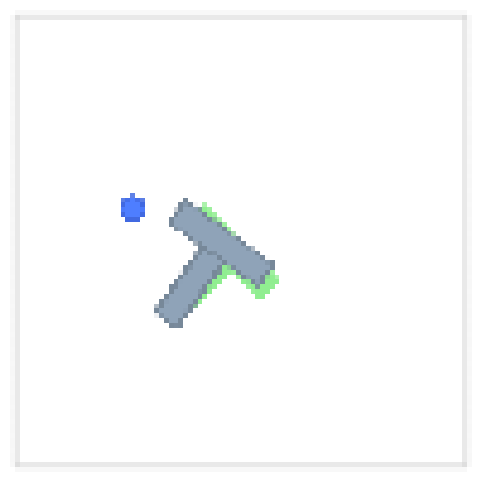

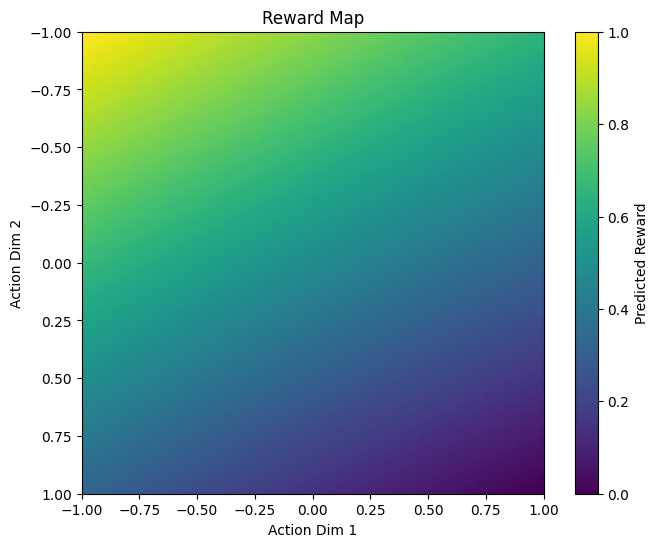

In [9]:
def generate_reward_map(policy, obs, state, resolution=100):
    """Generate a reward landscape by scanning over possible actions.
    Args:
        policy: The trained CVAE policy
        obs: Image observation tensor of shape (1,3,96,96) 
        state: State tensor of shape (1,2)
        resolution: Number of points to sample in each action dimension
        
    Returns:
        actions: (resolution*resolution, 14) tensor of sampled actions
        rewards: (resolution*resolution,) tensor of predicted rewards
    """
    # Encode state and observation
    with torch.no_grad():
        zs = policy.state_encoder(obs, state)
        
        # Create action grid from (-1,-1) to (1,1)
        x = torch.linspace(-1, 1, resolution)
        y = torch.linspace(1, -1, resolution)  # Reversed y range
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Create full action tensor with zeros
        actions = torch.zeros((resolution*resolution, 14), device=obs.device)
        # Fill first two dimensions with grid values
        for i in range(1):
            actions[:, 2*i] = xx.flatten()
            actions[:, 2*i+1] = yy.flatten()

        
        # Encode each action
        za_list = []
        rewards = []

        # Process in batches to avoid memory issues
        batch_size = 100
        z = torch.randn(1,64).repeat(batch_size,1).cuda()
        for i in range(0, len(actions), batch_size):
            action_batch = actions[i:i+batch_size]
            
            # Encode action
            za = policy.action_encoder(action_batch)
            
            # # Get latent from encoder
            # z_mu, z_logvar = policy.fusing_encoder(
            #     zs.repeat(len(action_batch),1), 
            #     za
            # )

            # z = policy.reparameterize(z_mu,z_logvar)
            
            
            # Decode reward
            reward = policy.reward_decoder(
                zs.repeat(len(action_batch),1),
                za, 
                z
            )
            rewards.append(reward)
            
        rewards = torch.cat(rewards, dim=0)
        
        rewards = rewards.squeeze(-1).cpu().numpy()

        # Normalize rewards to [0,1] range
        rewards = (rewards - rewards.min()) / (rewards.max() - rewards.min())

        action = actions.cpu().numpy()

        # Reshape rewards for plotting
        reward_grid = rewards.reshape(100,100)


        
        # Plot and save observation image
        dir = "./output/img"
        plt.figure(figsize=(8,6))
        obs_img = obs.squeeze().permute(1,2,0).cpu().numpy()
        plt.imshow(obs_img)
        plt.axis('off')
        plt.savefig(f'{dir}/observation.png')
        plt.show()
        
        # Plot and save reward map
        plt.figure(figsize=(8,6))
        plt.imshow(reward_grid, extent=[-1,1,1,-1], origin='lower')
        plt.colorbar(label='Predicted Reward')
        plt.xlabel('Action Dim 1')
        plt.ylabel('Action Dim 2') 
        plt.title('Reward Map')
        plt.savefig(f'{dir}/reward_map.png')
        plt.show()

        return action, rewards

# Example usage:
obs = batch['observation.image'][0].cuda()
state = batch['observation.state'][0].cuda()/512 * 2 - 1
action, rewards = generate_reward_map(policy, obs, state)


In [94]:
# config_dict = {
#         "horizon": 7,
#         "action_dim": 2,
#         "state_dim": 512*3*3 + 2,
#         "batch_size": 16,
#         "latent_dim_state": 50,
#         "latent_dim_action": 2,  # Same as action_dim
#         "posterior_dim": 64,
#         "beta": 1.0,
#         "training_steps": 3000,
#         "learning_rate": 3e-4,
#         "max_iterations": 50,
#         "step_size": 1e-4,
#         "damping": 1e-3,
#         "min_std": 1e-4,
#         "discount": 0.9,
#         "log_freq": 1,
#         "eval_freq": 40,
#         "output_directory": "./output",
#         "device": "cuda:0",
#         "gradient_accumulation_steps": 4,  # Added gradient accumulation config
#         "eval_split": 0.05
#     }

# config = Config(config_dict)
# policy_ = CVAEWithTrajectoryOptimization(config)

In [97]:
# checkpoint = torch.load("./output/best_model_/model.pt")

/tmp/ipykernel_2867674/804462426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/best_model_/model.pt")


In [100]:
# policy_.state_encoder.load_state_dict(checkpoint['state_encoder'])
# policy_.action_encoder.load_state_dict(checkpoint['action_encoder'])
# policy_.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
# policy_.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
# policy_.action_decoder.load_state_dict(checkpoint['action_decoder'])
# policy_.reward_decoder.load_state_dict(checkpoint['reward_decoder'])

<All keys matched successfully>

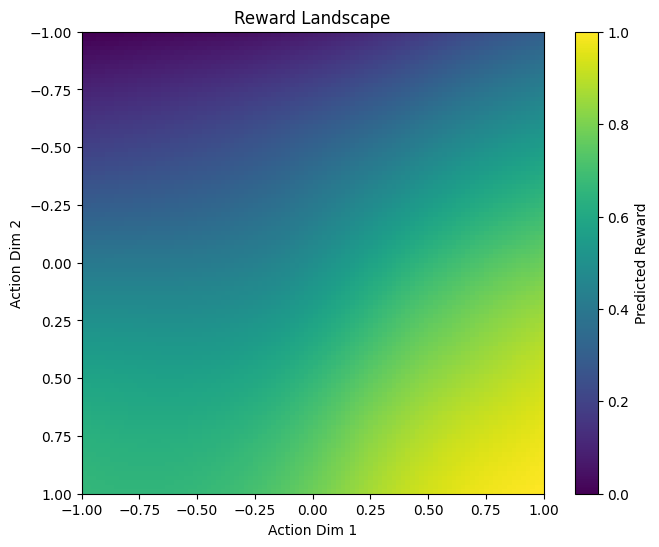

In [101]:
# action, rewards = generate_reward_map(policy_, obs, state)


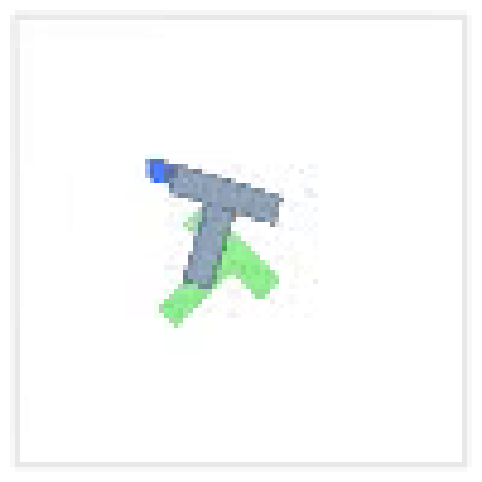

In [78]:
# plt.figure(figsize=(8,6))
# plt.imshow(obs.squeeze().permute(1,2,0).cpu().numpy())
# plt.axis('off')
# plt.show()